In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from matplotlib import mlab
from __future__ import print_function, division
import nsfg
import first
import thinkstats2
import thinkplot
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
import random

%matplotlib inline
sns.set()

C:\Users\Krystin\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
class HypothesisTest(object):

    def __init__(self, data, pool = []):
        self.data = data
        self.pool = pool
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        
        self.test_stats = [self.TestStatistic(self.RunModel()) for _ in range(iters)]
                
        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters
        

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()

# The Main Replace Project (MRP) Report
##  Exploratory Analysis<br>

My goal for this project is to prioritize leak prone Manhattans service for replacement.<br>

There are a number of questions that need answers before we can prioritize current leak prone pipe.<br>
> - What are the variables that affect pipe leakage? <br>
> -  Which variables are more important than others?<br>
>   location, pipe material, year installed, location of fault, cause of leak, customer type<br>
> - Can we predict the severity of the leak based on these variables?<br>

Once we know the answers to these questions I can use that information to assign an order to pipe that are most vulnerable y running a regression analysis.<br> 


The first step is to analyze the variables that cause leak using leakage data.<br>
The data, which was provided by engineering shows, Manhattan leak repairs from 2010-2017. 
This data has 21 data attributes:<br>

**InvgLeakTypeCd**:	Con Edison classification of leaks<br>
**CauseDesc**:  	        cause description<br>
**CauseCd**:	            cause the leak or the need for repair. You can look at CauseDesc (column B) to see what the codes mean.<br>
**OriginalSourceCd**:	    who found or reported the leak. For example, public, leak survey, leak mobile, fire department, etc.<br>
**Remarks**:	            general remarks<br>
**CauseRemarks**:	        remarks on cause<br>
**ActionCd**:	            action taken<br>
**RepairCd**:	            detail code of repair to the pipe<br>
**OriginalMaterialCd**:	    Material of service<br>
**NbrOfRepairs**:	        # of repairs to service<br>
**OriginalSize**:	        diameter of service<br>
**Footage**:	            length of service<br>
**PressureCd**:	            Gas pressure of service<br>
**BoroughCd**:	            Borough - Manhattan<br>
**AddrHouseNbr**:	        house number<br>
**AddrStreetName**:	        street address<br>
**MnSPlateNbr**:	        Con Edison splits service areas into grid(plates) <br>
**FacilityCd**:	            whether facility is a service or main(I'm looking at only services)<br>
**FacilityYearInstalled**:	Year service was installed<br>
**LocationFaultCd**:	    location of leak on the pipe<br>
**RepairDateTime**:	        time and date of repair<br>


In [3]:
df = pd.read_csv('../../ThinkStats2-master/leaks.csv')
df.head()

,InvgLeakTypeCd,CauseDesc,CauseCd,OriginalSourceCd,Remarks,CauseRemarks,ActionCd,RepairCd,OriginalMaterialCd,NbrOfRepairs,...,Footage,PressureCd,BoroughCd,AddrHouseNbr,AddrStreetName,MnSPlateNbr,FacilityCd,FacilityYearInstalled,LocationFaultCd,RepairDateTime
0,1,Other,OT,LMANNLPLKGSRVY,NaN,NaN,REPLACE,SRPP,STEEL,1,...,20.0,LOW,MANHATTAN,306,37,025-F,SERVICE,1929,NaN,4/24/2002 0:00
1,1,Other,OT,OTHERCOSOURCE,NaN,NaN,FIXREPAIR,SFF,STEEL,1,...,0.0,LOW,MANHATTAN,1054,3,032-J,SERVICE,1994,NaN,11/8/2008 0:00
2,1,Other,OT,LMSURVBUSLKGSRVY,NaN,NaN,FIXREPAIR,SFF,STEEL,1,...,0.0,LOW,MANHATTAN,1991,3,047-J,SERVICE,1996,NaN,6/26/2006 0:00
3,1,Other,OT,PUBLIC,NaN,NaN,REPLACE,SRF,STEEL,1,...,0.0,LOW,MANHATTAN,109,77,037-E,SERVICE,1974,NaN,12/6/2006 0:00
4,1,Corrosion/Graphitization,CG,FIRE,NaN,NaN,ABANDON,SA,STEEL,1,...,31.0,LOW,MANHATTAN,2129,3,049-J,SERVICE,1923,NaN,10/18/2007 0:00


###  1. Descriptive Statistics
The chart below shows a number of descriptive statistics that summarize the central tendency, dispersion and shape of a dataset's distribution.  This allows me to view any obvious errors in the data.<br>

Just from a glance we can see there are numerous errors in the data.<br>
Footage has a max of 1975 and FacilityYearInstalled has a max of 9999 both of which are not possible.

In [4]:
df.describe()

,NbrOfRepairs,OriginalSize,Footage,FacilityYearInstalled
count,3994.000000,3994.000000,1612.000000,3994.000000
mean,1.008262,2.184652,22.291563,1972.046820
std,0.117072,1.128978,71.574667,222.057286
min,1.000000,0.500000,0.000000,1832.000000
25%,1.000000,1.250000,3.000000,1952.000000
50%,1.000000,2.000000,19.000000,1975.000000
75%,1.000000,3.000000,26.000000,1984.000000
max,5.000000,20.000000,1975.000000,9999.000000


I believe the footage data error was cause when year data was inserted into footage column.
FacilityYearInstalled cannot be greater 2017

The following code handles these errors and shows the percentage of data that is affected by these errors.
I called the descriptive statistics again to show the error have been handled.


In [5]:
# Replace any leak that has a year greater than 2018
# year error is mostly likely to data entry error
year_replace = df[df['FacilityYearInstalled'] >= 2017].index
year = df[df['FacilityYearInstalled'] >= 2017]
frac_of_datasetyear = 100 * len(year) / len(df)

print('{0:.1f}% of leaks in raw data have a facility year error '.format(frac_of_datasetyear))

for x in year_replace:
    df.replace(df.FacilityYearInstalled[x], np.nan, inplace=True)

# Replace any leak that has a footage equal to facility year
# facility year somehow got copied into footage at some point   
foot_replace = df[df['Footage'] == df['FacilityYearInstalled'] ].index 
foot = df[df['Footage'] == df['FacilityYearInstalled'] ]
frac_of_datasetfoot = 100 * len(foot) / len(df)

print('{0:.1f}% of leaks in raw data have a footage error'.format(frac_of_datasetfoot))

for x in foot_replace:
    df.replace(df.Footage[x], np.nan, inplace=True)    
    

0.1% of leaks in raw data have a facility year error 
0.1% of leaks in raw data have a footage error


Now that we have removed the error from FacilityYearInstalled we can use the year in RepairDateTime to approximate the age of the pipe when it leaked. <br>
Note that the repair time is not the same as when the pipe was found leaking.  In fact repair time range from many days or even months greater than a leka found time

In [6]:
#change data type to datetime
df['RepairDateTime'] = pd.to_datetime(df['RepairDateTime'])
df['age'] = df['RepairDateTime'].apply(lambda t: t.year) - df['FacilityYearInstalled']
df.describe()

,NbrOfRepairs,OriginalSize,Footage,FacilityYearInstalled,age
count,3994.000000,3994.000000,1610.000000,3840.000000,3840.000000
mean,1.008262,2.184652,19.881988,1965.747656,46.616927
std,0.117072,1.128978,21.130592,29.917732,29.650352
min,1.000000,0.500000,0.000000,1832.000000,0.000000
25%,1.000000,1.250000,3.000000,1950.000000,28.000000
50%,1.000000,2.000000,19.000000,1976.000000,38.000000
75%,1.000000,3.000000,26.000000,1985.000000,62.000000
max,5.000000,20.000000,208.000000,2016.000000,184.000000


### 2. Types of Leaks

The following chart shows the amount different types of leak.

Type 1 - Potential hazard to life or property.  Requires continous attention until positive physical action eliminates hazard

Type 2 - No immedaite hazard to life or property. Inspect every 2 months and repair within 1 year<br>
        2A - Presents no immediate hazard to life or property but must be repaired within six (6) months of the time it was classified Type 2A or within the repair time remaining since the leak became workable, whichever is less and until repaired must be surveilled at intervals not to exceed two weeks <br>
        2M - Any reading on a leak detection device less than 4% in a Subsurface Structure(SSS) that is connected to one or more buildings or SSS and there is no access to at least one of these connected buildings<br>

Type 3 - No hazard to life or property.  Inspect annually or next scheduled leakage survey. No repair required

Type 4 - No leak found


Most of the leaks are type 1 leaks.

Types 2, 2A, & 2M are combined into type 2 leaks.  The leaving the type 2 data spilt creates a lot of noise which can make the 
Analyze hard to understand. Combining these into one type will also not affect the analysis as there is an only a small amount of 2A & 2M leaks.

To make things easier to understand I will create a new column name 'LeakType' which I will use for labeling graphs decribeing the level of risk

'1' = 'High' <br>
'2' = 'Meduim'<br>
'3' = 'Low'<br>
'4' = 'No leak'<br>

9.1% of leaks are 2A(Meduim) leaks
0.3% of leaks are 2M(Meduim) leaks


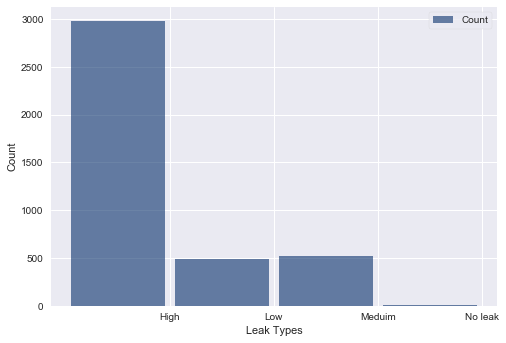

In [7]:
# Replace any 2, A, & M with 2 
A_replace = df[df['InvgLeakTypeCd'] == 'A' ].index
M_replace = df[df['InvgLeakTypeCd'] == 'M' ].index

frac_of_datasetleak = 100 * len(A_replace) / len(df)
print('{0:.1f}% of leaks are 2A(Meduim) leaks'.format(frac_of_datasetleak))
frac_of_datasetleak = 100 * len(M_replace) / len(df)
print('{0:.1f}% of leaks are 2M(Meduim) leaks'.format(frac_of_datasetleak))

for x in A_replace:
    df.replace(df.InvgLeakTypeCd[x], '2', inplace=True)
for y in M_replace:
    df.replace(df.InvgLeakTypeCd[y], '2', inplace=True)

#Creating new column to make data easier to understand visually
df['LeakType'] = df['InvgLeakTypeCd']
df.loc[df['InvgLeakTypeCd'] == '1', 'LeakType'] = 'High'
df.loc[df['InvgLeakTypeCd'] == '2', 'LeakType'] = 'Meduim'
df.loc[df['InvgLeakTypeCd'] == '3', 'LeakType'] = 'Low'
df.loc[df['InvgLeakTypeCd'] == '4', 'LeakType'] = 'No leak'
    

leak_type = df['LeakType'].sort_index()
labelT = np.asarray(leak_type)

hist = thinkstats2.Hist(leak_type, label='Count')
thinkplot.Hist(hist)
thinkplot.Config(xlabel='Leak Types', ylabel='Count')

plt.show()


Most of the leaks are High risk which are the most dangerous types of leaks.
The least amount of leaks are type 4 which tells us that it is very rare for a leak to be reported and it not be a leak.

###  3.0 Cause of Leaks
What are the most common causes of leaks?<br>
Luckly our data set has a column 'CauseDesc' that describes the cause of the leak<br>
Some of the causes are within Con Edison's control(i.e contractor damage) while others are natural occurances that are not within Con Edison's control (i.e. Corrosion/graphitizatio)<br>
The bar chart below that the amount of each cause based on leak type.<br>


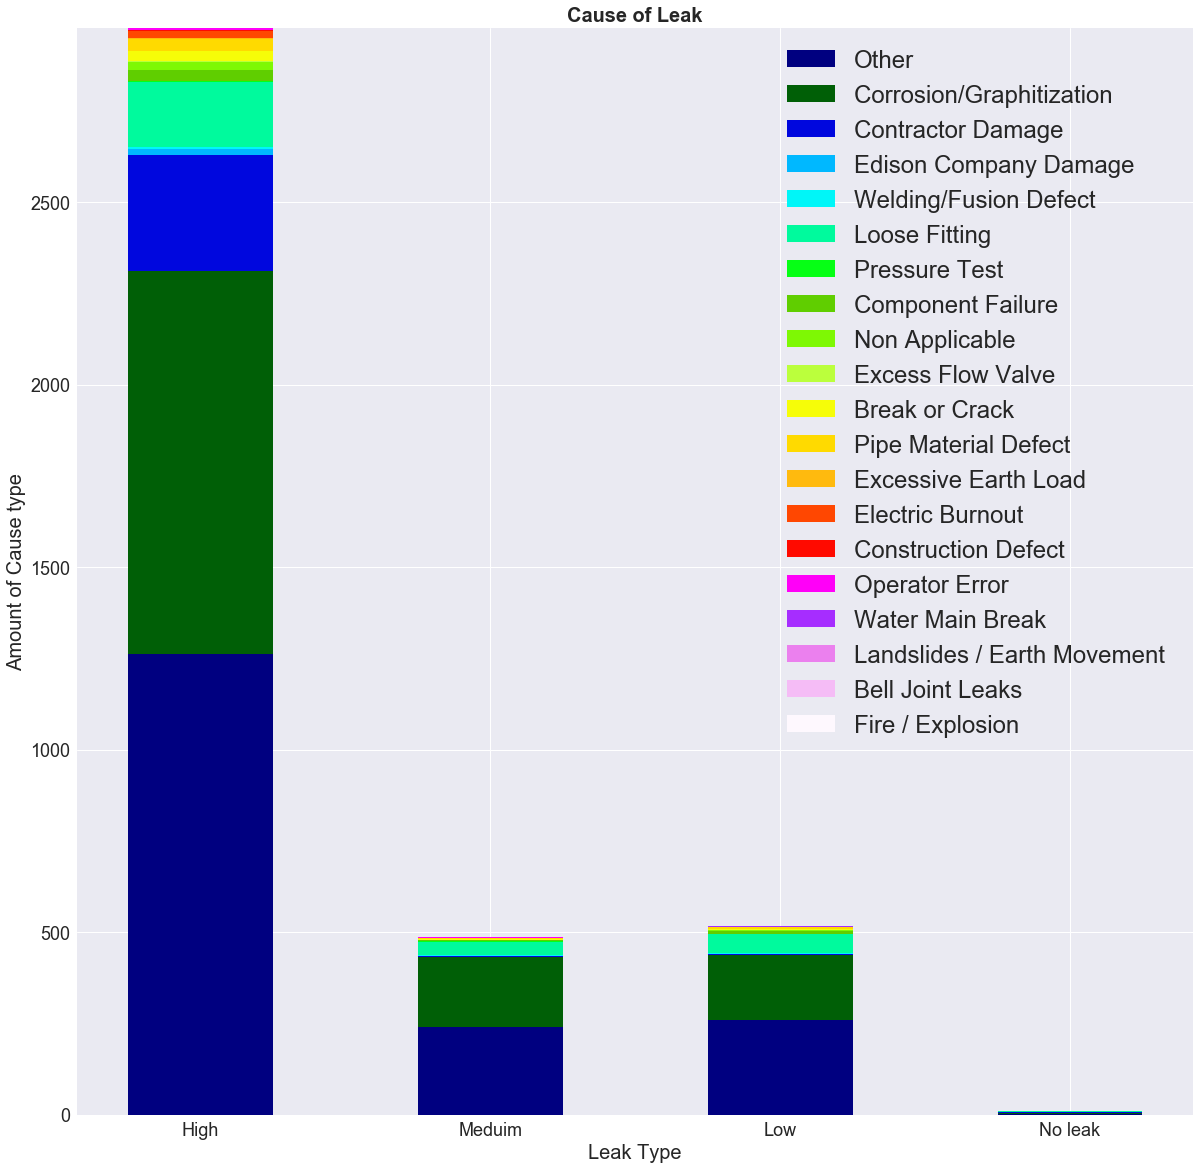

In [8]:
cause = df['CauseDesc'].value_counts()
cause_type = df['CauseDesc'].unique()

labelT = df['LeakType'].unique()


fig, ax = plt.subplots(figsize=(20,20))
y_offset = np.zeros(len(labelT))
colors = plt.cm.gist_ncar(np.linspace(0, 1.0, len(cause_type))) #+ plt.cm.(np.linspace(0, 2.0, len(cause_type)/2))

i = 0
for Ctype in cause_type:
    bytype = (df[df['CauseDesc'] == Ctype])
    cause = bytype['LeakType'].value_counts().sort_index()
    for Ltype in labelT:
        if Ltype in cause:
            pass
        else:
            s = pd.Series([0], index=[Ltype])
            cause = cause.append(s)
            
    cause_array  = np.asarray(cause.sort_index())
    
    ax.bar(range(len(labelT)), cause_array, width=0.5, bottom=y_offset, label=Ctype, color = colors[i])
    y_offset = y_offset + cause_array
    i += 1


    
ax.grid(True)
ax.legend(loc='best', fontsize = 24)
ax.set_title('Cause of Leak', fontsize=20, fontweight='bold')
ax.set_xlabel('Leak Type', fontsize=20)
plt.xticks(range(len(labelT)), labelT, fontsize = 18)
ax.set_ylabel('Amount of Cause type',fontsize=20) 
plt.yticks(fontsize = 18)

plt.show()


As High risk is the most prevalent of the leak types it is hard to observe the causes of the other type<br>
In order to fix this the data has to be normalized.<br>

#### 3.1 Normalization

This chart shows the normailization of the cause type which makes it easier to ready acroos the other leak types.<br>


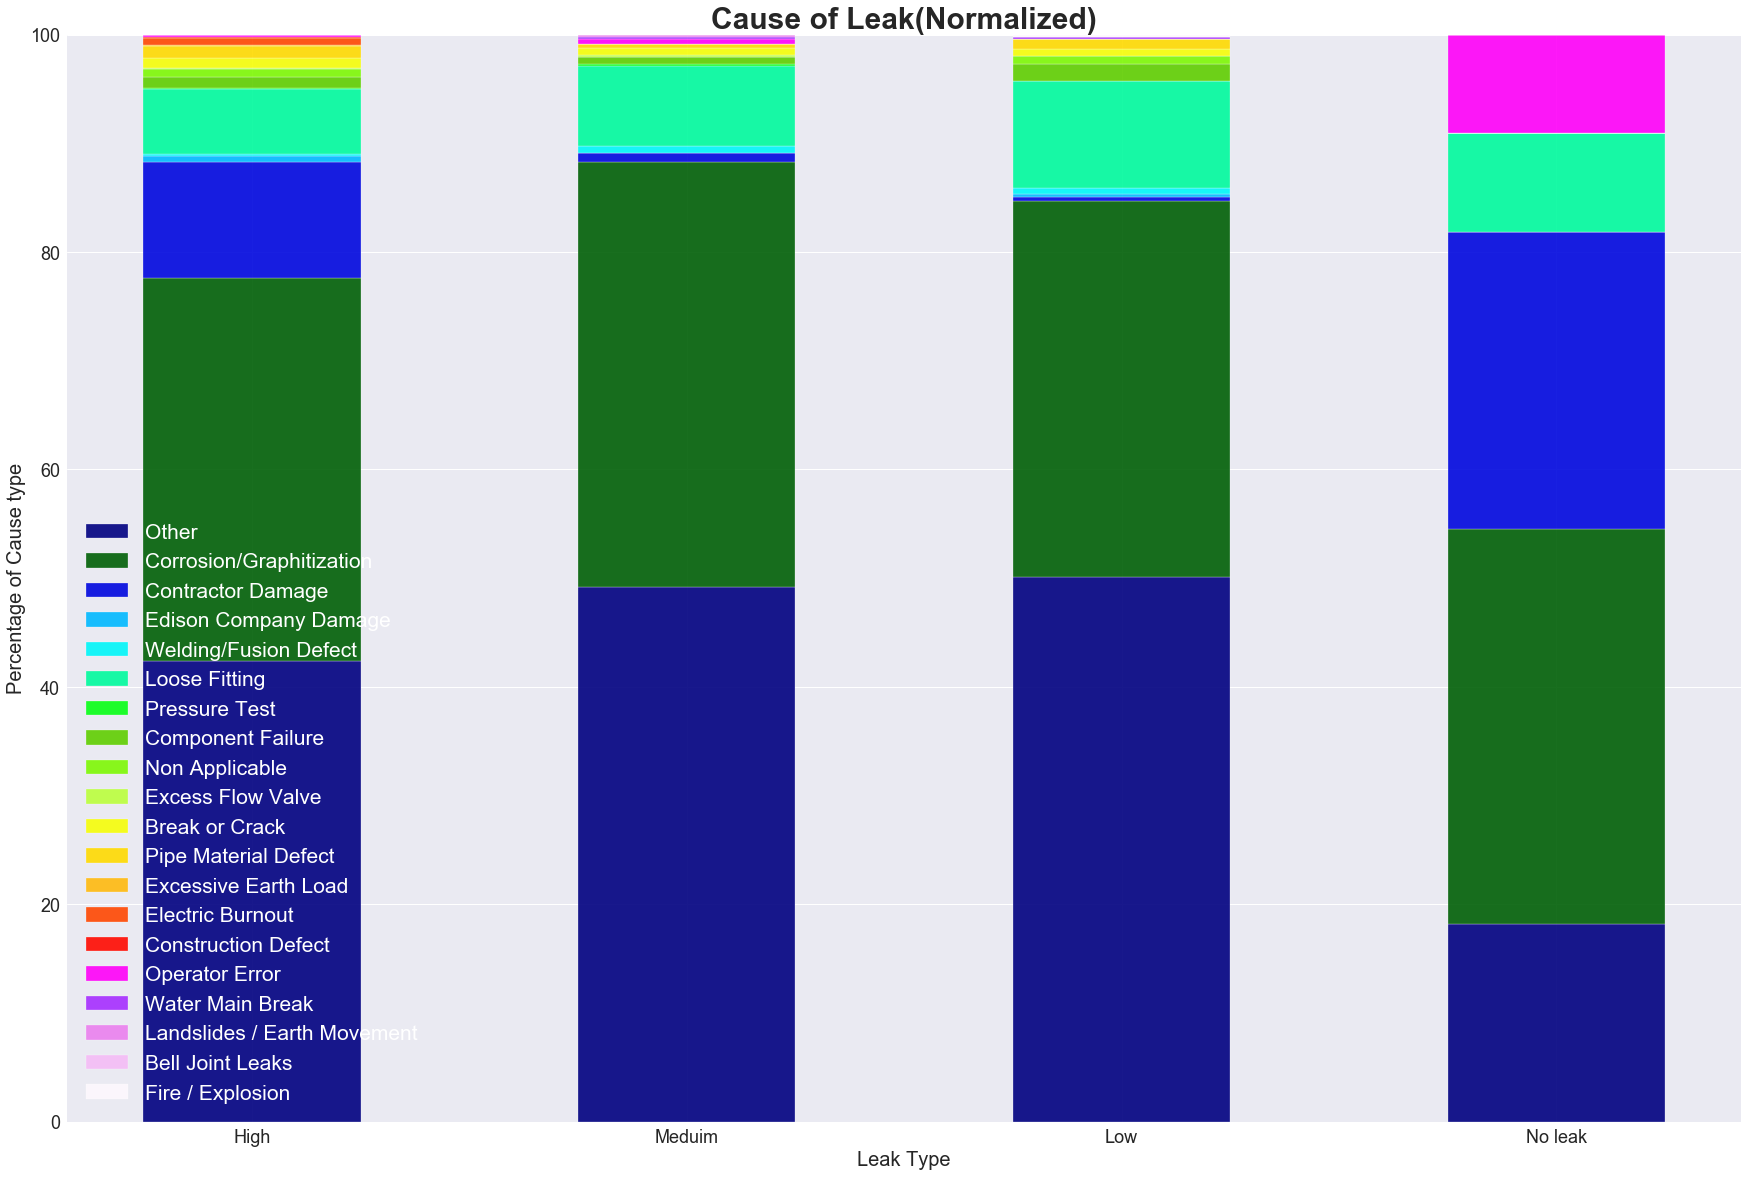

In [9]:
causeleak = df[['CauseDesc', 'LeakType']]
pivot = causeleak.pivot_table(index = 'LeakType', columns='CauseDesc',aggfunc=np.count_nonzero)
pivot.replace(np.nan, 0.0, inplace=True)
#print(pivot)

totals = np.asarray(pivot.sum(axis=1))

bar_l = [i for i in range(len(totals))] 
f, ax = plt.subplots(1, figsize=(30,20))
colors = plt.cm.gist_ncar(np.linspace(0, 1.0, len(cause_type)))
y_offset = np.zeros(len(totals))
c=0
for Ctype in cause_type:    
    perc = [i / j * 100 for  i,j in zip(pivot[Ctype], totals)]
    ax.bar(bar_l, perc, label= Ctype, alpha=0.9, color=colors[c], width=0.5,bottom=y_offset, edgecolor='white')
    y_offset = y_offset + np.asarray(perc)
    c += 1
    
ax.grid(True)
ax.set_title('Cause of Leak(Normalized)', fontsize=30, fontweight='bold')
leg = ax.legend(loc='best', fontsize = 21)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
ax.set_xlabel('Leak Type', fontsize=20)
plt.xticks(range(len(labelT)), labelT, fontsize = 18)
ax.set_ylabel('Percentage of Cause type',fontsize=20) 
plt.yticks(fontsize = 18)

plt.show()   

On this chart we can see that the most common causes(that are not other) are corrosion/graphitization, loose fitting, & contractor damages.<br>
1. Corrosion/graphitization is a natural occurance that happend when the pipe breaks down. <br>
2. A loose fitting is can be caused when the fitting was installed improperly or due to natural shift in the ground. <br>
3. Contractor damage is when a contractor damages the pipe and causes a leak. <br>

### 4 Material Type

The chart shows the material type of each type of leak.<br>
Services can be made of steel, copper or plastic.

Note: 'PEB' 'PEYS' & 'PEY' have all been changed to 'PLASTIC' as the amount of each is so small it only creates noise and the only difference between them is color (PE = Plastic, B = black, Y = yellow)

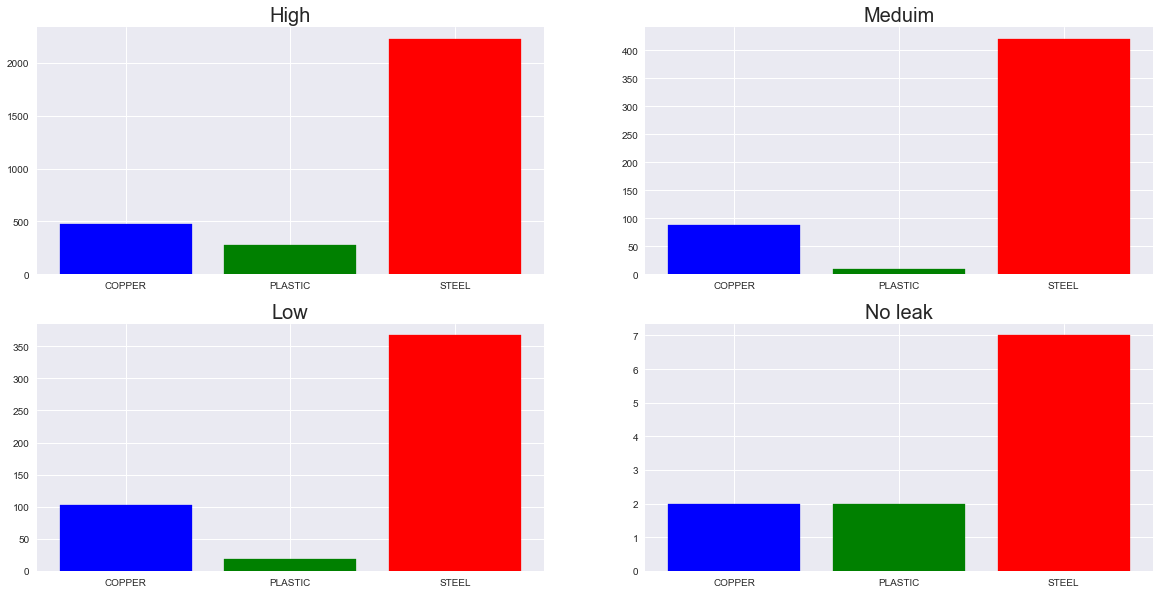

In [10]:
#PEY PEYS PEB are all plastic 
colors=['blue', 'green', 'red']
Y_replace = df[df['OriginalMaterialCd'] == 'PEY' ].index
YS_replace = df[df['OriginalMaterialCd'] == 'PEYS' ].index
B_replace = df[df['OriginalMaterialCd'] == 'PEB' ].index


for x in Y_replace:
    df.replace(df.OriginalMaterialCd[x], 'PLASTIC', inplace=True)
for y in YS_replace:
    df.replace(df.OriginalMaterialCd[y], 'PLASTIC', inplace=True)
for z in B_replace:
    df.replace(df.OriginalMaterialCd[z], 'PLASTIC', inplace=True)
    
Omaterial_type = df['OriginalMaterialCd'].unique()
Omaterial_type.sort()  

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
i=0
for Ltype in labelT:
    bytype = (df[df['LeakType'] == Ltype])
    material = bytype['OriginalMaterialCd'].value_counts().sort_index()
    for Otype in Omaterial_type:
        if Otype in material:
            pass
        else:
            s = pd.Series([0], index=[Otype])
            material = material.append(s)
    material_array  = np.asarray(material.sort_index())
    
    ax = axes[i // 2, i % 2]
    barlist = ax.bar(range(len(Omaterial_type)),material_array)
    for j in range(len(material)):
        barlist[j].set_color(colors[j])
    ax.set_title(Ltype, fontsize=20)
    i+=1

plt.setp(axes,xticks=range(len(Omaterial_type)), xticklabels=Omaterial_type)    
plt.show()


For each leak type the most likely material is steel followed by copper.  This makes sense as it was established before the most common cause is corrosion which only happens on metal pipes.   

### 5 Fault Location

Now that we know that Corrosion/graphitizatiois the most common cause we can use 'LocationFaultCd' to show which parts of the pipe are mroe vulnerable to failure.

The following bar chart shows the fault locations for each type of leak


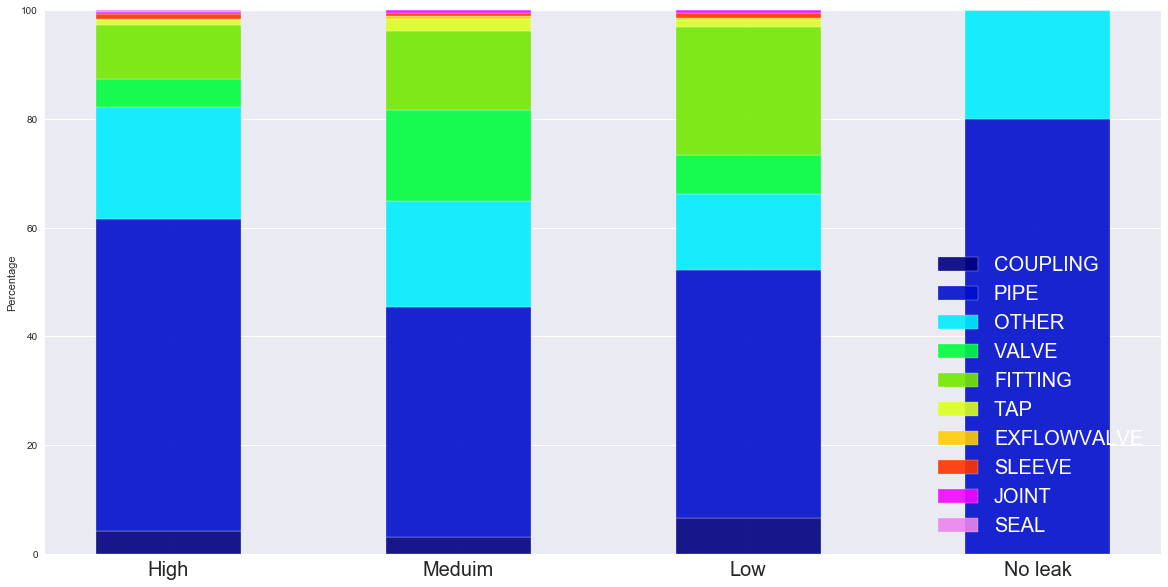

In [11]:
Locfault = df[['LocationFaultCd', 'InvgLeakTypeCd']]

pivotloc = Locfault.pivot_table(index = 'InvgLeakTypeCd', columns='LocationFaultCd',aggfunc=np.count_nonzero)
pivotloc.replace(np.nan, 0.0, inplace=True)

loc_type = df['LocationFaultCd'].unique()
loc_type_no_nan = np.delete(loc_type, 0)

totals = np.asarray(pivotloc.sum(axis=1))

bar_l = [i for i in range(len(totals))] 
f, ax = plt.subplots(1, figsize=(20,10))
colors = plt.cm.gist_ncar(np.linspace(0, 1.0, len(loc_type)))
y_offset = np.zeros(len(totals))
c=0
for loctype in loc_type_no_nan:
    perc = [i / j * 100 for  i,j in zip(pivotloc[loctype], totals)]
    ax.bar(bar_l, perc, label= loctype, alpha=0.9, color=colors[c], width=0.5,bottom=y_offset, edgecolor='white')
    y_offset = y_offset + np.asarray(perc)
    c += 1

ax.set_ylabel("Percentage")
ax.set_xlabel("")
plt.xticks(range(len(labelT)), labelT, fontsize = 20)
leg = ax.legend(loc='best', fontsize = 20)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
# shot plot
plt.show()  

Most of the faults happen on the pipe itself followed by valve and the fitting.

### 6 Diameter of Pipe

The following shows CDFs of each leak type based on the diameter of the pipe.

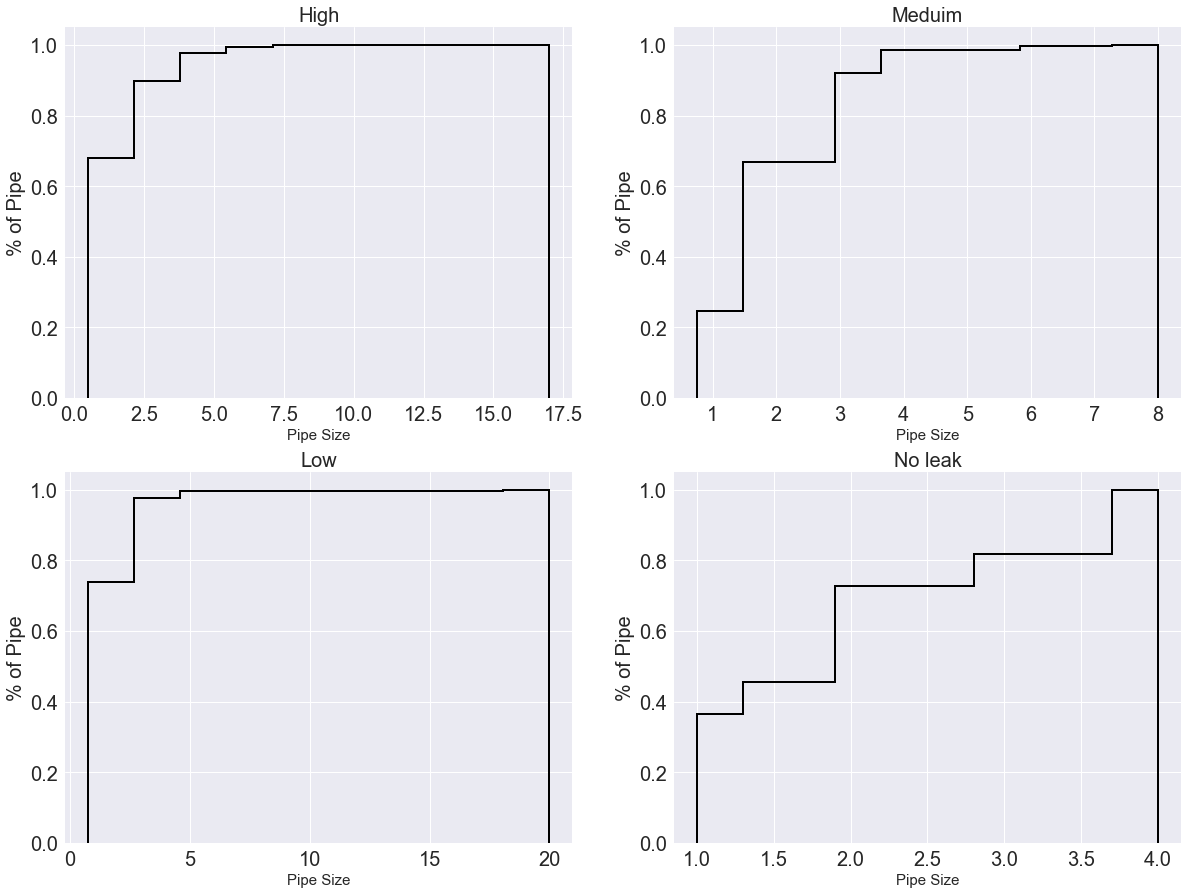

In [12]:
O_size = df['OriginalSize']

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

i=0
for Ltype in labelT:
    bytype = (df[df['LeakType'] == Ltype])
    O_size = bytype['OriginalSize']
    size_array = np.asarray(O_size.dropna())
    ax = axes[i // 2, i % 2]
    ax.hist(size_array,label=Ltype,normed=True,cumulative=True, histtype='step',linewidth = 2, edgecolor = 'black')
    ax.set_title(Ltype, fontsize=20)
    ax.set_xlabel('Pipe Size', fontsize=15)
    ax.set_ylabel('% of Pipe',fontsize=20)
    ax.tick_params(labelsize = 20)
    i+=1




plt.show() 

Based on these charts it can be determined that most leaks occur on smaller pipes.  
This makes sense because pipes with a smaller diameter are weaker than pipes with a larger diameter.

### 7 Scatter Plots

Now I look at realtionships between different variables.

The following scatter matrix shows the scatter plots for OriginalSize, Footage, NbrOfRepairs, FacilityYearInstalled, & age.
And the correspoding correlation to age and FacilityYearInstalled.

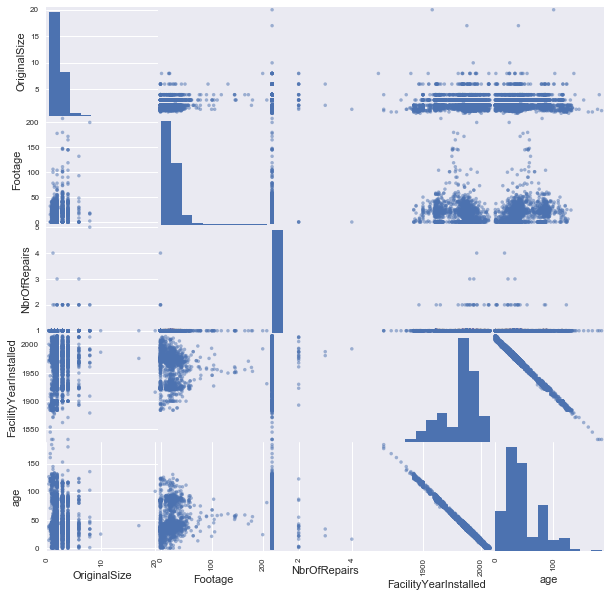

In [13]:
pd.plotting.scatter_matrix(df[['OriginalSize', 'Footage', 'NbrOfRepairs', 'FacilityYearInstalled', 'age']],
                       figsize=(10,10))
plt.show()

In [14]:
print(df.corr(method='spearman').loc['FacilityYearInstalled'],'\n')
print(df.corr(method = 'spearman').loc['age'])

NbrOfRepairs             0.042892
OriginalSize            -0.112841
Footage                 -0.178370
FacilityYearInstalled    1.000000
age                     -0.983959
Name: FacilityYearInstalled, dtype: float64 

NbrOfRepairs            -0.037679
OriginalSize             0.120165
Footage                  0.233440
FacilityYearInstalled   -0.983959
age                      1.000000
Name: age, dtype: float64


I'm going to ignore the plots and high correlation(0.98) for FacilityYearInstalled and age because we already know how they are related (age = RepairYear - FacilityYearInstalled)

I'm more interested in  the realtioship between age and Footage, and age and Orginalsize.

So lets take a closer look at their scatter plots

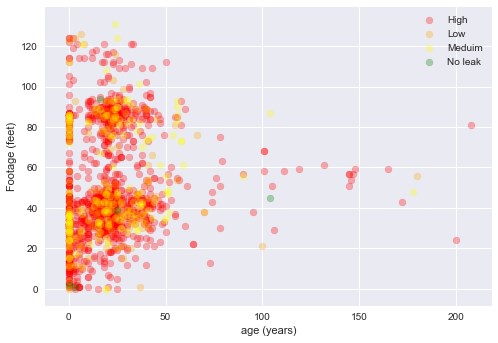

In [15]:
grouped = df.groupby('LeakType')
GasType = {}
for name, group in grouped:
    GasType[name] = group 

colors = ['red','orange','yellow','green']
for i, (name, data) in enumerate(GasType.items()):
    plt.scatter(data.Footage, data.age, c=colors[i], label=name, alpha=0.3)

plt.ylabel('Footage (feet)')
plt.xlabel('age (years)')
plt.legend()

plt.show()

From the scatter plot I observe that footage aroudd 80' and 40' seem to have a concentrated age spread betwen 10 & 50 years.  While footage around 60 feet has more spread.

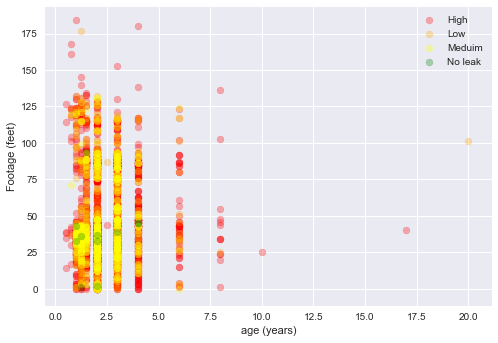

In [16]:
grouped = df.groupby('LeakType')
GasType = {}
for name, group in grouped:
    GasType[name] = group 

colors = ['red','orange','yellow','green']
for i, (name, data) in enumerate(GasType.items()):
    plt.scatter(data.OriginalSize, data.age, c=colors[i], label=name, alpha=0.3)

plt.ylabel('Footage (feet)')
plt.xlabel('age (years)')
plt.legend()

plt.show()



I'm also interested in  the realtioship between FacilityYearInstalled and Footage(correlation: -0.179292) , and FacilityYearInstalled and OrginalSize(-0.110980) despite having very little correlation

I want to learn if certain years are more likely to have longer footage and therefore more likely to have leaks.
I also want to learn if certain years have had smaller pipes installed as that is also likely to have an effect on the number of leaks

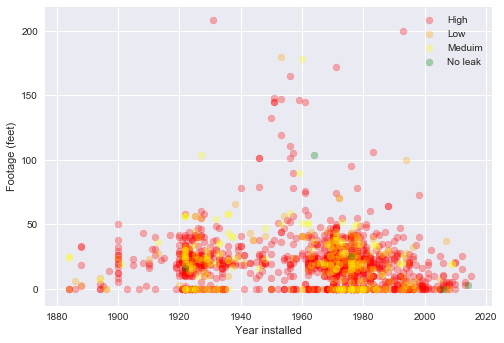

In [17]:
grouped = df.groupby('LeakType')
GasType = {}
for name, group in grouped:
    GasType[name] = group 

colors = ['red','orange','yellow','green']
for i, (name, data) in enumerate(GasType.items()):
    plt.scatter(data.FacilityYearInstalled, data.Footage, c=colors[i], label=name, alpha=0.3)

plt.ylabel('Footage (feet)')
plt.xlabel('Year installed')
plt.legend()

plt.show()


From the scatter plot I observe that pipes with longer footage were more likely installed after 1930 but the amount of longer footage (50' and above) dwindles after 1950


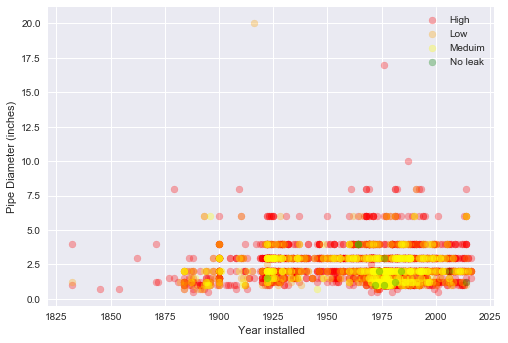

In [18]:
colors = ['red','orange','yellow','green']
for i, (name, data) in enumerate(GasType.items()):
    plt.scatter(data.FacilityYearInstalled, data.OriginalSize, c=colors[i], label=name, alpha=0.3)

plt.ylabel('Pipe Diameter (inches)')
plt.xlabel('Year installed')
plt.legend()

plt.show()

From the scatter plot I observe that smaller pipes are installed consistently across the years until 1975 when the cocentration of pipe less than 2.5" almost doubles  This may account for the reason 

###  8 Year Installed - Analysis

#### 8.1 CDF

I predict that year installed and age will become our most important variables.
Both Corrosion and loose fitting are natural causes that happend over time.

I first start with a cdf analysis of FacilityYearInstalled.


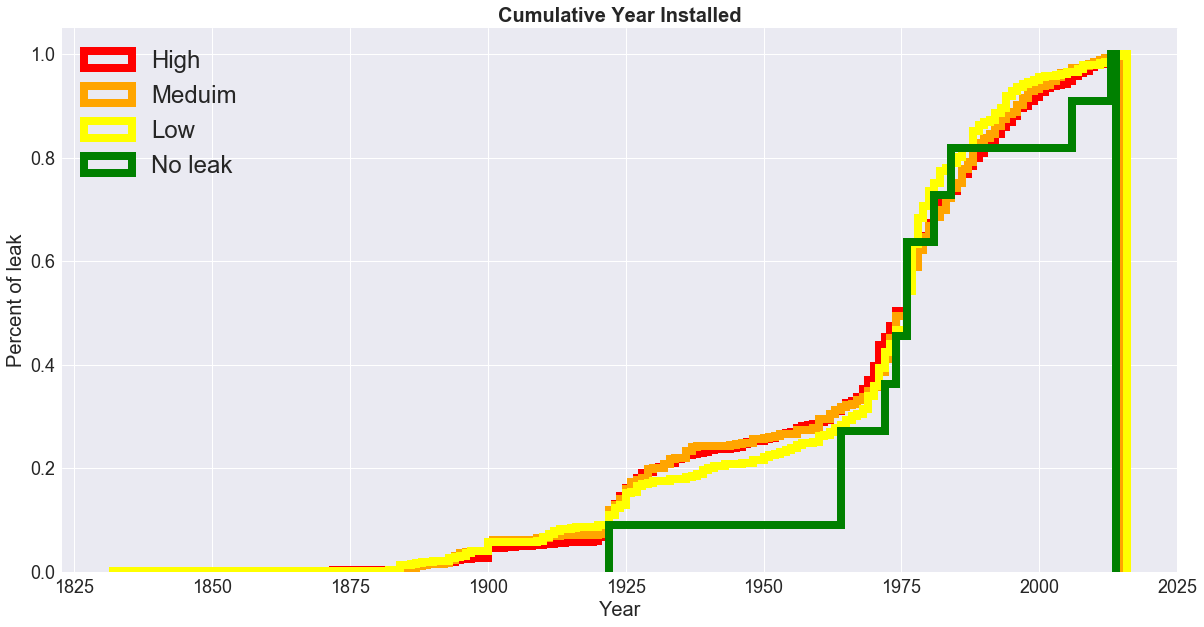

In [19]:
fig, ax = plt.subplots(figsize=(20,10))
colors = ['red','orange','yellow','green']
i=0

labelT = df['LeakType'].unique()


for Ltype in labelT:
    bytype = (df[df['LeakType'] == Ltype])
    year_installed = bytype['FacilityYearInstalled']
    yeari_array = np.asarray(year_installed.dropna())
    bin = int(yeari_array.max() - yeari_array.min())
    ax.hist(yeari_array,bins=bin,normed=True  ,cumulative=True, histtype='step', label=Ltype, linewidth = 8,color=colors[i])
    i += 1


ax.grid(True)
ax.legend(loc='best', fontsize = 24)
ax.set_title('Cumulative Year Installed', fontsize=20, fontweight='bold')
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Percent of leak',fontsize=20)
plt.xticks(fontsize = 18) 
plt.yticks(fontsize = 18)

plt.show()



This chart shows a cumulative distribution function(CDF) of the different leak types based on the year the facility was installed.  

The first item to note is that types 1,2,& 3 all have a similar is distribution. 

We can also note certain years which are more prone to leakage: 1900, 1925, & 1975.

The chart below shows the pdf of year installed.<br>
The pdf shows more clearly three different spikes in leaks near the years 1900, 1925, & 1975.

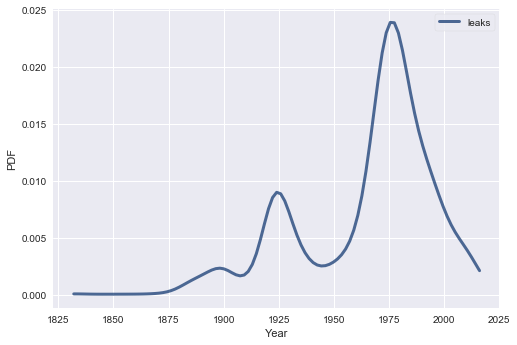

In [20]:
year_installed = df['FacilityYearInstalled']
year_installed.dropna(inplace=True)
pdf = thinkstats2.EstimatedPdf(year_installed)
thinkplot.Pdf(pdf, label='leaks')
thinkplot.Config(xlabel='Year', ylabel='PDF')

Using percentile rank I look ata range of years near 1900, 1925, & 1975 in order to find the years where the increase occured.
the three leaks occured in 1900, 1922, & 1976.

In [21]:
year_installed = df['FacilityYearInstalled']
yearinstalled_cdf = thinkstats2.Cdf(year_installed, label='yearinstalled')

median = yearinstalled_cdf.Percentile(50)
print('Median:', median)

sample = [1899, 1900, 1901]
ranks = [yearinstalled_cdf.PercentileRank(x) for x in sample]
print("Percentile Ranks for 1899, 1900, 1901: ", ranks)

sample = [1921, 1922, 1923]
ranks = [yearinstalled_cdf.PercentileRank(x) for x in sample]
print("Percentile Ranks for 1921, 1922, 1923: ", ranks)

sample = [1974, 1975, 1976, 1977, 1978]
ranks = [yearinstalled_cdf.PercentileRank(x) for x in sample]
print("Percentile Ranks for 1974 - 1978: ", ranks)


Median: 1976.0
Percentile Ranks for 1899, 1900, 1901:  [3.0208333333333335, 4.9479166666666661, 5.0]
Percentile Ranks for 1921, 1922, 1923:  [7.6041666666666661, 11.328125, 12.942708333333334]
Percentile Ranks for 1974 - 1978:  [49.84375, 49.84375, 55.677083333333336, 60.130208333333336, 63.567708333333329]


This plot shows the CDF of year installed for all leaks and compares it to a Normal CDF.<br>
Just based on this comparision a normal distribution follows the general trend the best but it is still not a great fit.

Mean, Var 1966.15993624 805.095036765
low, high 1832.0 2016.0
Sigma 28.3741966717


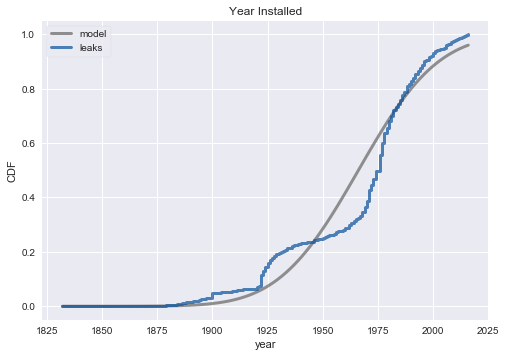

In [22]:
# estimate parameters: trimming outliers yields a better fit
year_installed = df['FacilityYearInstalled']
year_installed.dropna(inplace=True)
mu, var = thinkstats2.TrimmedMeanVar(year_installed, p=0.01)
print('Mean, Var', mu, var)

Llow = year_installed.min() 
Lhigh = year_installed.max()

print('low, high', Llow, Lhigh)
    
# plot the model
sigma = np.sqrt(var)
print('Sigma', sigma)
xs, ps = thinkstats2.RenderNormalCdf(mu, sigma, low=Llow, high=Lhigh)

thinkplot.Plot(xs, ps, label='model', color='0.4')

# plot the data
cdf = thinkstats2.Cdf(year_installed, label='leaks')

thinkplot.PrePlot(1)
thinkplot.Cdf(cdf) 
thinkplot.Config(title='Year Installed', xlabel='year',   ylabel='CDF')



This plot shows the complement CDF of year installed for all leaks.

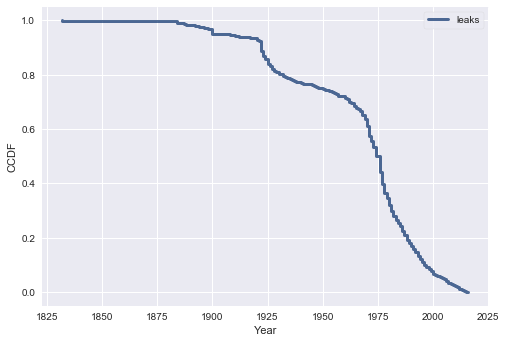

In [23]:
year_cdf = thinkstats2.Cdf(year_installed, label='leaks')
thinkplot.Cdf(year_cdf,complement=True)
thinkplot.Config(xlabel='Year', ylabel='CCDF')



This is the normal probability plot for year installed for all leaks.
this confirms what I mentioned before, the normal probabilty distribution follows the general trend but it not a good fit especially at the ends


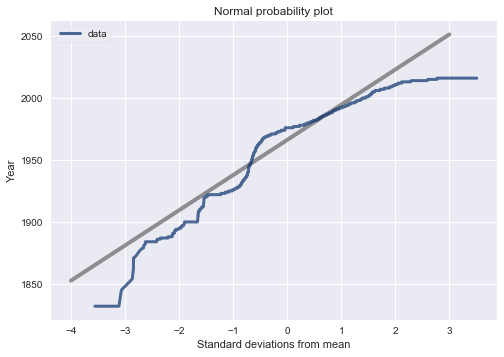

In [24]:
mean, var = thinkstats2.TrimmedMeanVar(year_installed, p=0.01)
std = np.sqrt(var)

xs = [-4,3]
fxs, fys = thinkstats2.FitLine(xs, mean, std)
thinkplot.Plot(fxs, fys, linewidth=4, color='0.4')

xs, ys = thinkstats2.NormalProbability(year_installed)
thinkplot.Plot(xs, ys, label='data')

thinkplot.Config(title='Normal probability plot', xlabel='Standard deviations from mean',ylabel='Year')

#### 8.2  Time series analysis 

First I plot the time series scatter plot of the number of leaks per year for each type of leak



In [25]:
def Count(data, func=np.count_nonzero):
    """Groups transactions by day and compute the daily mean ppg.

    transactions: DataFrame of transactions

    returns: DataFrame of daily prices
    
    """
    sf = data['FacilityYearInstalled'].value_counts().sort_index()
    grouped = pd.DataFrame({'yearInstalled':sf.index, 'freq':sf.values})
    grouped.set_index('yearInstalled', inplace=True)
    return grouped


In [26]:
grouped = df.groupby('LeakType')
GasType = {}
for name, group in grouped:
    GasType[name] = Count(group) 


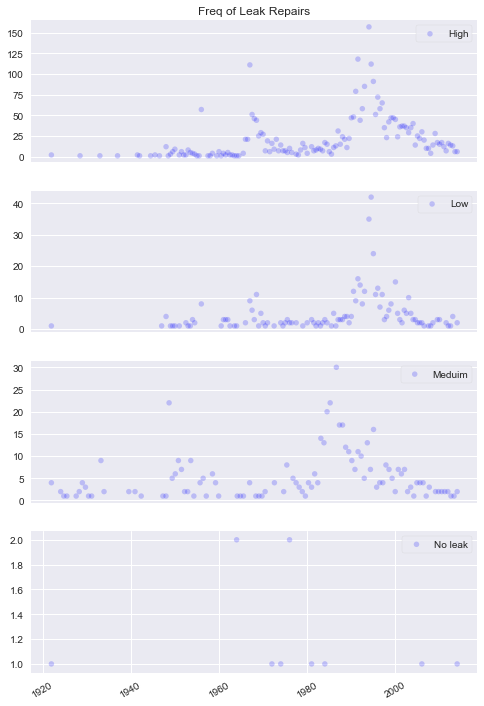

In [27]:
thinkplot.PrePlot(rows=4)
for i, (name, daily) in enumerate(GasType.items()):
    thinkplot.SubPlot(i+1)
    title = 'Freq of Leak Repairs' if i == 0 else ''
    thinkplot.Config(title=title)
    thinkplot.Scatter(daily.freq, s=30,label=name)
    if i == 3: 
        plt.xticks(rotation=30)
        thinkplot.Config()
    else:
        thinkplot.Config(xticks=[])

This plot breaks down each type of leak into time series graph.  
Both low and high leaks seem to have the same type of graph while meduim leaks are shifted to the left 

In [28]:
def PlotEWMA(daily, name):
    """Plots rolling mean.

    daily: DataFrame of daily prices
    """
    dates = range(int(daily.index.min()), int(daily.index.max()))
    reindexed = daily.reindex(dates)

    thinkplot.Scatter(reindexed.freq, s=30, alpha=0.2, label=name)
    roll_mean = pd.ewma(reindexed.freq, 30)
    thinkplot.Plot(roll_mean, label='EWMA', color='#ff7f00')
    plt.xticks(rotation=30)
    thinkplot.Config(ylabel='count')

C:\Users\Krystin\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=30,min_periods=0,adjust=True,ignore_na=False).mean()
  # Remove the CWD from sys.path while we load stuff.


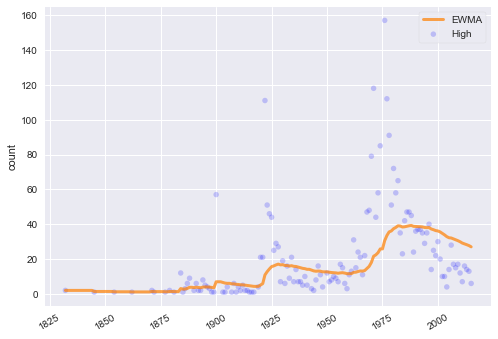

In [29]:
PlotEWMA(GasType["High"], "High")

The exponentially-weighted moving average doesn't fit particually well with the time series so its not useful for my analysis.

1 Year(s)


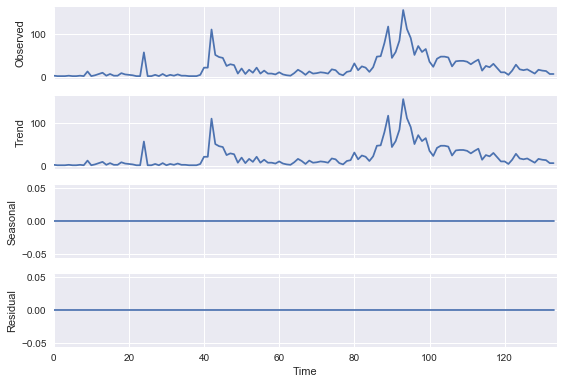

5 Year(s)


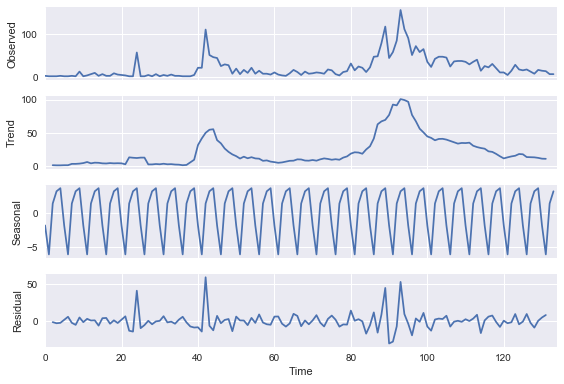

10 Year(s)


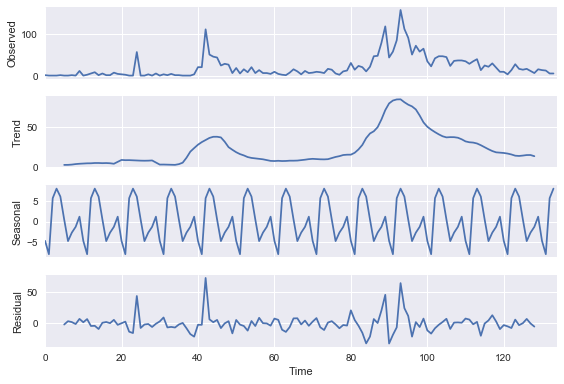

20 Year(s)


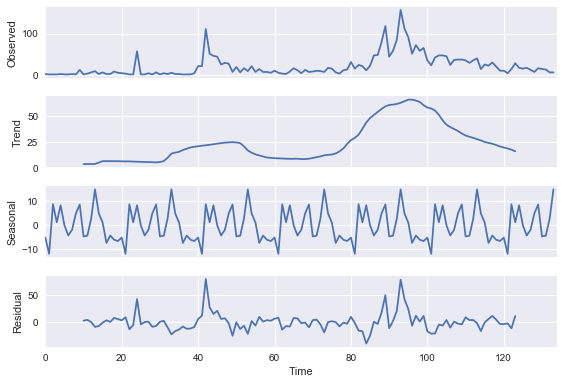

50 Year(s)


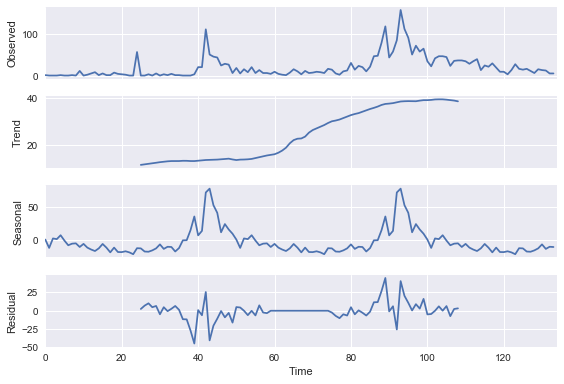

In [30]:
series = np.array(GasType['High'].freq)

for i in [1,5,10,20,50]:
    print(i, "Year(s)")
    result = seasonal_decompose(series, model='additive', freq=i)
    result.plot()    
    plt.show()

By comparing the different trends and seasonality we can see that there is not a discernible pattern for any frequencies

#### 8.3 ANOVA Hypothesis Test

I created the boxplot for age for each time of leak.
From the box plot it looks 

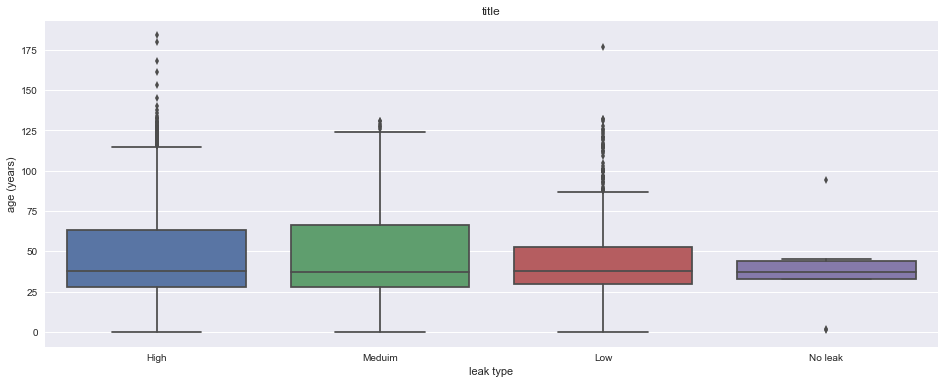

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

sns.boxplot(x="LeakType", y="age", data=df, ax=ax)

ax.set_title('title')
ax.set_xlabel('leak type')
ax.set_ylabel('age (years)')
ax.set_xticklabels(labelT)

plt.show()

ANOVA (analysis of variance), which is a statistical technique for determining the existence of differences among several means

H: All means are not the same <br>
NH: The means of each leak type group is the same<br>
Model:permutation (shuffle leak types)<br>
Test stat: F-ratio, Ratio of Variance Between and Variance Within

If the NH is true(all the means are equal) then the variance between the samples is 0 and therfore the F-ratio is 0. <br>
If the NH is not true, then this F-ratio will be larger, the more likely it is that the null hypothesis will be rejected.

"When we set a significance level at the start of our statistical tests (usually 0.05), we are saying that if our variable in question takes on the 5% ends of our distribution, then we can start to make the case that there is evidence against the null, which states that the data belongs to this particular distribution." (https://plot.ly/python/anova/)

In [32]:
class ANOVA(HypothesisTest):

    def TestStatistic(self, data):
    
        # F-ratio = Variance between groups / variance within groups
        group1, group2, group3, group4 = data
        #between sum of squares
        BSS = sum([(len(_df[_df.LeakType == l]))*(_df[_df.LeakType ==l].age.mean()-self.grand_mean)**2 for l in _df.LeakType])
        #print(BSS)
        #Between Mean Squares
        BMS = BSS/self.DFbetween     
        #within sum of squares
        WSS = sum((len(_df[_df.LeakType == l])-1)*(_df[_df.LeakType == l].age.std())**2 for l in _df.LeakType)
        #print(WSS)
        #Within Mean Squares
        WMS = WSS/self.DFwithin
        #print(WMS)
        #F-ratio
        test_stat= BMS/WMS
        self.pvalue = stats.f.sf(test_stat, self.DFbetween,self.DFwithin)        
        return test_stat
    
    def MakeModel(self):
        group1, group2, group3, group4 = self.data
        self.n, self.m, self.o, self.p = len(group1), len(group2), len(group3), len(group4)
        self.pool = np.hstack((group1, group2, group3, group4))
        self.grand_mean = self.pool.mean()
        self.k = len(pd.unique(df.LeakType))  # number of conditions
        self.N = len(self.pool)
        self.n = df.groupby('LeakType').size() #Participants in each condition
        self.DFbetween = self.k - 1
        self.DFwithin = self.N - self.k
        self.DFtotal = self.N - 1
        
    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:self.n+self.m],self.pool[self.n+self.m:self.o+self.n+self.m], self.pool[self.o+self.n+self.m:]
        return data

In [33]:
grouped = df.groupby('LeakType')
GasType = {}
for name, group in grouped:
    GasType[name] = group 

_df = df[~df['age'].isnull()]
_df.reset_index()
    
data = GasType['High'].age.dropna(),GasType['Meduim'].age.dropna(), GasType['Low'].age.dropna(),GasType['No leak'].age.dropna()

HT = ANOVA(data)
print("F ratio:",HT.actual,"p-value: ",HT.pvalue)



F ratio: 0.020154146809 p-value:  0.996116152344


The F-ratio is 0.020 which is lower than the 0.05 threshold. So we can conclude that  the NH is true(all the means are equal).

The probability of seeing the F-ratio = 0.02 if the null hypothesis is true 99.6% in our model<br>

Therefore we do accept NH that all means are equal.

#### 8.4 Multinomial Regression Test

In [34]:
formula= 'LeakType ~ age'
model = smf.mnlogit(formula, data=df)

results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.757753
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                 3840
Model:                        MNLogit   Df Residuals:                     3834
Method:                           MLE   Df Model:                            3
Date:                Tue, 19 Dec 2017   Pseudo R-squ.:               0.0002590
Time:                        12:31:17   Log-Likelihood:                -2909.8
converged:                       True   LL-Null:                       -2910.5
                                        LLR p-value:                    0.6805
=======================================================================================
    y=LeakType[Low]       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.8092      0.093    -19.427      0.000      -1.992      -1.627
age                    -0.0002      0.002     -0.097      0.922      -0.003       0.003
---------------------------------------------------------------------------------------
y=LeakType[Meduim]       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.7719      0.090    -19.628      0.000      -1.949      -1.595
age                    0.0007      0.002      0.442      0.658      -0.002       0.004
--------------------------------------------------------------------------------------
y=LeakType[No leak]       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -5.0181      0.552     -9.098      0.000      -6.099      -3.937
age                    -0.0131      0.012     -1.052      0.293      -0.037       0.011
=======================================================================================
"""

R-Squared value of 0.0002590 indicating very low predictive power. 
However, the p-value associated with the intercept  are ver high, indicating age isn't statistically significant. 

This makes sense with the ANOVA test whihch concludes that the means are all equal

#### 8.5 Survival Analysis

Look at the survial ofa service pipe based on the age of the pipe.


In [35]:
import survival

def MakeSurvivalFromCdf(cdf, label=''):
    """Makes a survival function based on a CDF.

    cdf: Cdf
    
    returns: SurvivalFunction
    """
    ts = cdf.xs
    ss = 1 - cdf.ps
    return survival.SurvivalFunction(ts, ss, label)

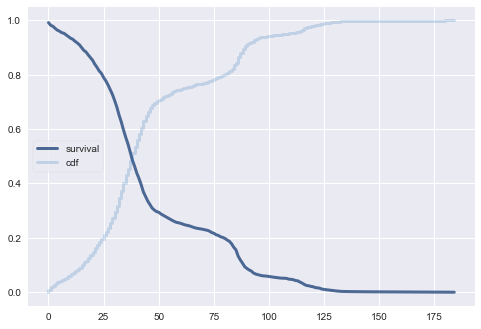

In [36]:
_df = df[~df['age'].isnull()]
_df.reset_index()
cdf = thinkstats2.Cdf(_df['age'], label='cdf')
sf = MakeSurvivalFromCdf(cdf, label='survival')
thinkplot.Plot(sf)
thinkplot.Cdf(cdf, alpha=0.2)
thinkplot.Config(loc='center left')

This survival curve shows the percentof pipe that proceed past a given age  

The survival curve shows that pipe rarely last longer that 50 years.<br>
In fact the pipes survial drop dramtically betwenn 25 and 50.<br>
80% of pipe survial past age 25 but only 30% survial past age 50. <br>

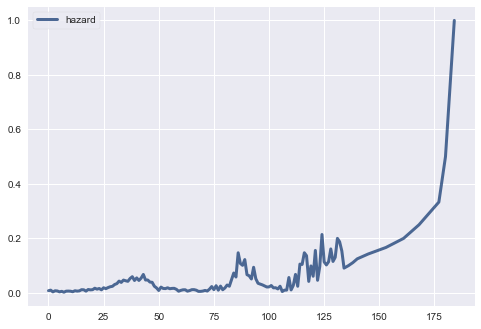

In [37]:
hf = sf.MakeHazardFunction(label='hazard')
thinkplot.Plot(hf)
thinkplot.Config(loc='upper left')

This Hazard funstion shows the fraction of pipes that continue until age t and then end at  age t.

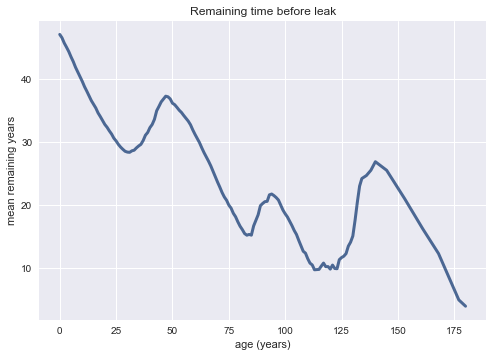

In [38]:
rem_life1 = sf.RemainingLifetime()
thinkplot.Plot(rem_life1)
thinkplot.Config(title='Remaining time before leak',
                 xlabel='age (years)',
                 ylabel='mean remaining years')

We can compute the expected time until pipe failure.  This is very interesting as the genral trend of the of the mean remaining years decreases but it spikes at age 50, 90, & 135.

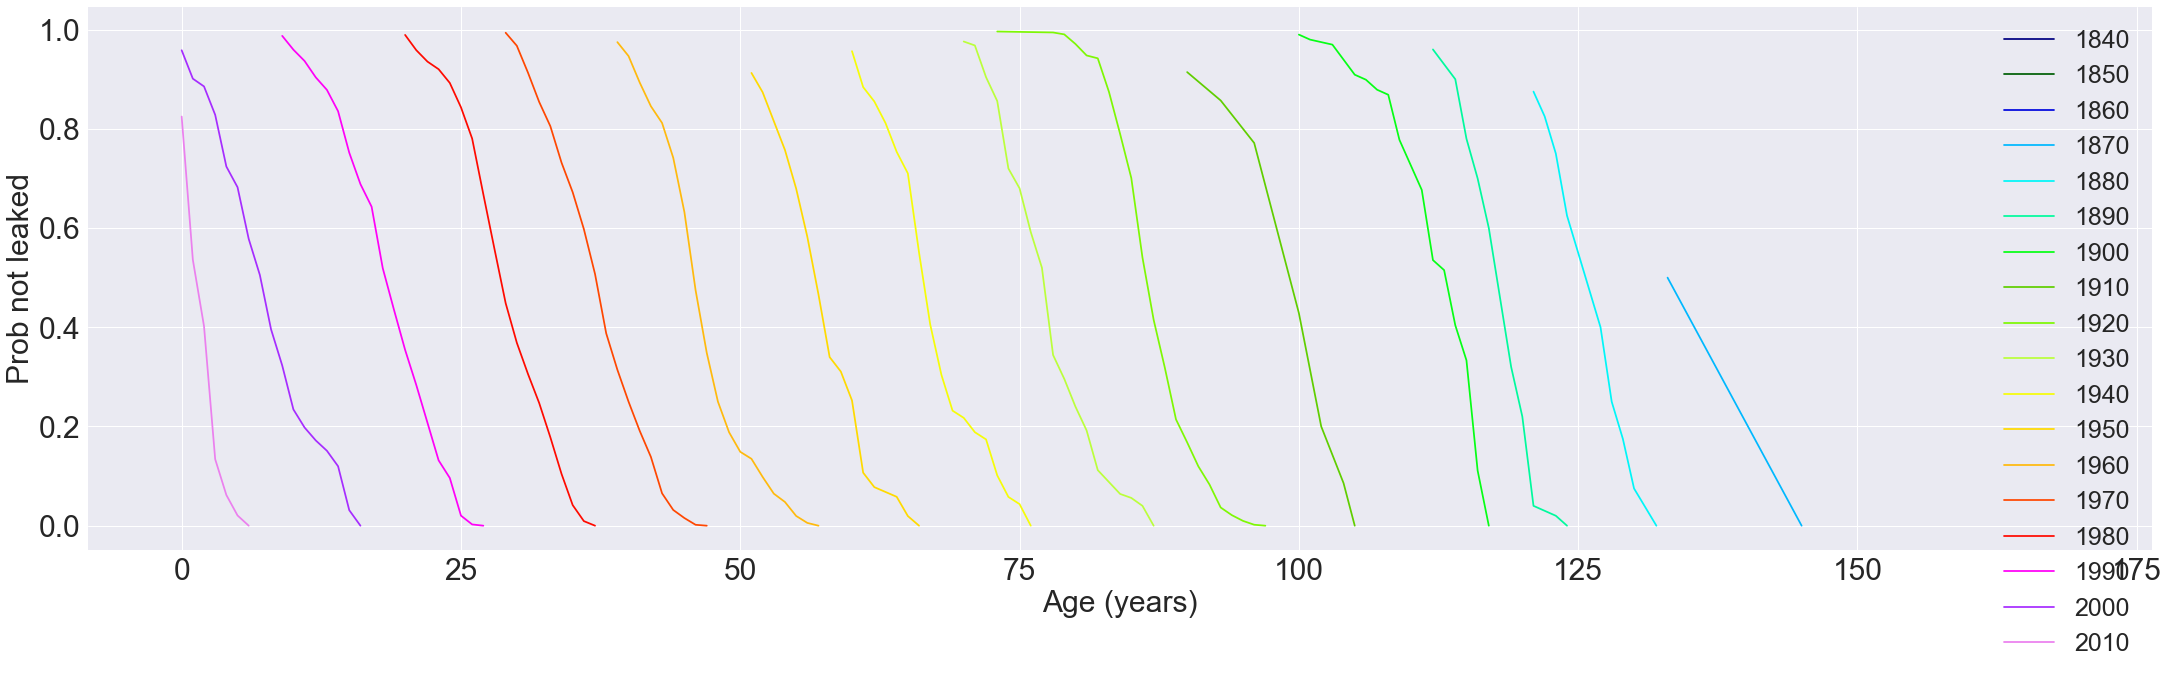

In [39]:
_df = df[~df['age'].isnull()]
_df = _df[~_df['FacilityYearInstalled'].isnull()]
_df.reset_index()

_df['decade'] = ((_df['FacilityYearInstalled']) / 10).astype(int, copy = False)
_df.head()


fig, ax = plt.subplots(figsize=(37,10))    
colors = plt.cm.gist_ncar(np.linspace(0, 1.0, 20))

#resample rows
for i in range(100):
    samples = [thinkstats2.ResampleRows(_df)]
    sample = pd.concat(samples, ignore_index=True)
    grouped = sample.groupby('decade')

#group by decade
decade = {}
for name, group in grouped:
    decade[name] = group    
    
for i, (name, group) in enumerate(decade.items()):
    cdf = thinkstats2.Cdf(group.age, label='cdf')
    sf = MakeSurvivalFromCdf(cdf, label='survival')
    ax.plot(sf.ts, sf.ss, color = colors[i], label = str(name)+"0")
    
    
ax.set_ylabel("Prob not leaked", fontsize= 30)
ax.set_xlabel("Age (years)", fontsize = 30)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
ax.legend(loc='best', fontsize = 25)


plt.show()  



The plot above show the survial curves for diffrent decades of pipe.  
As the pipe get older the less data we have on each pipe.
Also the younger the pipe is the lower is its age will be when it leaks which explains why each survival curve increases across the age axis as each decade get lower.

### 9 Mapping

The final image is map of Manhattan that illustrates the concentration of leaks based on MS plate number.
Unfortunately the address data that was provided to me was incomplete.  (The leak data did not provide whether the street were 'E' or 'W', or whether the streets were 'st' or 'ave' which is extremely important to have in Manhattan) 

We are able to see pockets where the most leaks occur.


In [40]:
df.MnSPlateNbr = df['MnSPlateNbr'].str.strip().replace('\s+', '_') 
df.MnSPlateNbr = df['MnSPlateNbr'].str.replace('--', '-')
df['grid_split'] = df['MnSPlateNbr'].str.split('-')
grid_ln = pd.DataFrame(df.MnSPlateNbr.str.split('-',1).tolist(),columns = ['number','letter'])
frames = [df, grid_ln]
df = pd.concat(frames,axis=1)

df.head()

,InvgLeakTypeCd,CauseDesc,CauseCd,OriginalSourceCd,Remarks,CauseRemarks,ActionCd,RepairCd,OriginalMaterialCd,NbrOfRepairs,...,MnSPlateNbr,FacilityCd,FacilityYearInstalled,LocationFaultCd,RepairDateTime,age,LeakType,grid_split,number,letter
0,1,Other,OT,LMANNLPLKGSRVY,NaN,NaN,REPLACE,SRPP,STEEL,1,...,025-F,SERVICE,1929.0,NaN,2002-04-24,73.0,High,"[025, F]",025,F
1,1,Other,OT,OTHERCOSOURCE,NaN,NaN,FIXREPAIR,SFF,STEEL,1,...,032-J,SERVICE,1994.0,NaN,2008-11-08,14.0,High,"[032, J]",032,J
2,1,Other,OT,LMSURVBUSLKGSRVY,NaN,NaN,FIXREPAIR,SFF,STEEL,1,...,047-J,SERVICE,1996.0,NaN,2006-06-26,10.0,High,"[047, J]",047,J
3,1,Other,OT,PUBLIC,NaN,NaN,REPLACE,SRF,STEEL,1,...,037-E,SERVICE,1974.0,NaN,2006-12-06,32.0,High,"[037, E]",037,E
4,1,Corrosion/Graphitization,CG,FIRE,NaN,NaN,ABANDON,SA,STEEL,1,...,049-J,SERVICE,1923.0,NaN,2007-10-18,84.0,High,"[049, J]",049,J


This piece of code removes any MS plates errors.  Letters only go from A-Z, and numbers only go up to 99.
Any MS plates that have this error have been removed.

In [41]:
pivot = df.pivot_table(columns='letter',aggfunc=np.count_nonzero)
df['number'].value_counts().sort_index()
df.number = df.number.astype(float)

number_replace = df[df['number'] >= 99.0].index
number = df[df['number'] >= 99.0]
frac_of_number = 100 * len(number) / len(df)

df = df[df['number'] <= 99.0]

print('{0:.1f}% of leaks in raw data have a MS plate error '.format(frac_of_number))

df.reset_index(drop=True, inplace=True)

1.8% of leaks in raw data have a MS plate error 


As mentioned before letter can only be one digit between A-Z<br>
This removes any double letter and converts itto a single letter (Ex. AA -> A)

In [42]:
#repace any non 1 letter  
for i in range(len(df)):
    if len(df.letter[i]) > 1:
        a = df.letter[i]
        b= df.MnSPlateNbr[i]
        df.replace(df.letter[i], a[:1], inplace=True)
        df.replace(df.MnSPlateNbr[i], b[:5], inplace=True)
    


This piece of code creates a pivot table that will be used to make the map of leaks.

In [43]:
mapleak = df[['MnSPlateNbr', 'InvgLeakTypeCd']]
pivot = mapleak.pivot_table(index = 'MnSPlateNbr', columns='InvgLeakTypeCd',aggfunc=np.count_nonzero)
pivot.replace(np.nan, 0.0, inplace=True)


mapleak = df[['number', 'letter', 'InvgLeakTypeCd']]
pivot = mapleak.pivot_table(index = 'number', columns='letter',aggfunc=np.count_nonzero)


Finally I can create the map with letters representing columns and numbers representing rows on a grid.

The legend repsrents number of leaks in the grid area with red being 35 and above and blue being 0.

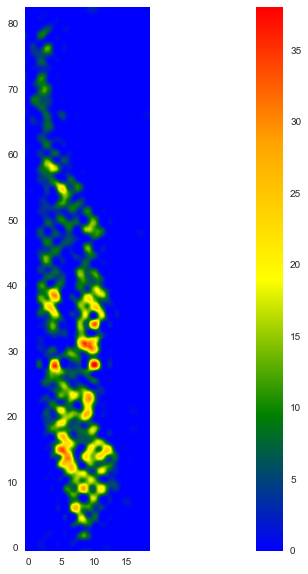

In [44]:
pivot.replace(np.nan, 0, inplace=True)
grid_list = pivot.values.tolist()

import matplotlib as mpl
from matplotlib import pyplot
import numpy as np

alphabet = ['A','B','C','D','E,'F',G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
fig = pyplot.figure(figsize=(38,10))

#fig = pyplot.figure(figsize=(99,len(alphabet)))

cmap = mpl.colors.LinearSegmentedColormap.from_list('colors',['blue','green','yellow','orange','red'], 300)


img = pyplot.imshow(grid_list,interpolation='sinc',cmap = cmap,origin='lower')

pyplot.colorbar(img,cmap=cmap)

pyplot.grid(False)

pyplot.show()


Based on the map most leaks occur in Mid-east Manhattan.

#### 9.1 Mapping Hypothesis Test

H: The location of leaks are significant  <br>
NH: The location of leaks are  random<br>
Model: Randomly choose MS plates and compute the frequencies
Test stat: Chi-squared

In [45]:
class location(HypothesisTest):
    
    def MakeModel(self):
        self.n = len(self.pool.unique())
        self.values = self.pool.unique()
        hist = thinkstats2.Hist(self.pool)
        self.total = hist.Total()
        self.expected = np.ones(self.n) * self.total / self.n
           
        
    def RunModel(self):
        leaks = np.random.choice(self.values, self.total, replace=True)
        hist = thinkstats2.Hist(leaks)
        freqs = hist.Freqs(self.values)
        return freqs
  
    def TestStatistic(self, data):
        observed = data
        test_stat = sum((observed - self.expected)**2 / self.expected)
        return test_stat

In [46]:
pool = df['MnSPlateNbr']

hist = thinkstats2.Hist(pool.sort_index(), label='Count')
data = hist.Freqs(hist.Values())

ht = location(data, pool)
p_value = ht.PValue()
print('p-value =', p_value)
print('actual =', ht.actual)
print("max", np.array(ht.test_stats).max())

p-value = 0.0
actual = 2866.62181448
max 657.931702345


The chi-squared test stat will never get higher than the actual therefore teh p value is 0 and we reject the NH that the locations are random

#### 9.2 Mapping Regression Test

Test out which variables are better predictors for leak type:<br>
1. letter + number <br>
2. using MnSPlateNbr

In [47]:
formula= 'LeakType ~ C(letter) + C(number)'
model = smf.mnlogit(formula, data=df)

results = model.fit(method='bfgs')
results.summary()


         Current function value: 0.723617
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


C:\Users\Krystin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                 3924
Model:                        MNLogit   Df Residuals:                     3621
Method:                           MLE   Df Model:                          300
Date:                Tue, 19 Dec 2017   Pseudo R-squ.:                 0.04832
Time:                        12:31:31   Log-Likelihood:                -2839.5
converged:                      False   LL-Null:                       -2983.6
                                        LLR p-value:                    0.6759
=======================================================================================
    y=LeakType[Low]       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.7023      2.954     -0.576      0.564      -7.491       4.087
C(letter)[T.B]          0.1240      2.427      0.051      0.959      -4.633       4.882
C(letter)[T.C]         -0.3450      2.340     -0.147      0.883      -4.931       4.241
C(letter)[T.D]         -0.8977      2.334     -0.385      0.700      -5.472       3.676
C(letter)[T.E]         -0.6574      2.341     -0.281      0.779      -5.246       3.931
C(letter)[T.F]         -0.0651      2.337     -0.028      0.978      -4.645       4.515
C(letter)[T.G]          0.0469      2.340      0.020      0.984      -4.539       4.632
C(letter)[T.H]          0.0843      2.340      0.036      0.971      -4.502       4.671
C(letter)[T.I]         -0.1057      2.340     -0.045      0.964      -4.692       4.480
C(letter)[T.J]         -0.1552      2.339     -0.066      0.947      -4.739       4.428
C(letter)[T.K]          0.0913      2.338      0.039      0.969      -4.491       4.674
C(letter)[T.L]         -0.0529      2.343     -0.023      0.982      -4.646       4.540
C(letter)[T.M]          0.3839      2.354      0.163      0.870      -4.229       4.997
C(letter)[T.N]          0.1057      2.383      0.044      0.965      -4.565       4.776
C(letter)[T.O]         -0.0489      3.470     -0.014      0.989      -6.849       6.752
C(letter)[T.P]         -0.0560      3.176     -0.018      0.986      -6.281       6.169
C(letter)[T.R]         -0.0490      3.448     -0.014      0.989      -6.807       6.709
C(letter)[T.T]         -0.0235      4.637     -0.005      0.996      -9.113       9.066
C(letter)[T.Y]         -0.0277      3.771     -0.007      0.994      -7.420       7.364
C(number)[T.2.0]        0.0607      2.245      0.027      0.978      -4.340       4.462
C(number)[T.3.0]        0.1267      1.943      0.065      0.948      -3.681       3.935
C(number)[T.4.0]       -0.1076      2.420     -0.044      0.965      -4.850       4.635
C(number)[T.5.0]        0.3619      1.866      0.194      0.846      -3.296       4.020
C(number)[T.6.0]        0.0713      1.906      0.037      0.970      -3.664       3.807
C(number)[T.7.0]        0.5423      1.845      0.294      0.769      -3.073       4.158
C(number)[T.8.0]        0.2154      1.870      0.115      0.908      -3.450       3.881
C(number)[T.9.0]       -0.4812      1.878     -0.256      0.798      -4.162       3.199
C(number)[T.10.0]      -0.6295      1.850     -0.340      0.734      -4.255       2.996
C(number)[T.11.0]      -0.2479      1.854     -0.134      0.894      -3.882       3.386
C(number)[T.12.0]      -1.0341      1.885     -0.549      0.583      -4.728       2.660
C(number)[T.13.0]      -0.2929      1.841     -0.159      0.874      -3.902       3.316
C(number)[T.14.0]       0.4510      1.830      0.246      0.805      -3.135       4.037
C(number)[T.15.0]       0.3141      1.826      0.172      0.863      -3.264       3.892
C(number)[T.16.0]       0.3839      1.825      0.210      0.833      -3.1

In [48]:
formula= 'LeakType ~ C(MnSPlateNbr)'
model = smf.mnlogit(formula, data=df)

results = model.fit(method = 'bfgs')
results.summary()

         Current function value: 0.644065
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


C:\Users\Krystin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                 3924
Model:                        MNLogit   Df Residuals:                     2274
Method:                           MLE   Df Model:                         1647
Date:                Tue, 19 Dec 2017   Pseudo R-squ.:                  0.1529
Time:                        12:31:57   Log-Likelihood:                -2527.3
converged:                      False   LL-Null:                       -2983.6
                                        LLR p-value:                     1.000
=============================================================================================
          y=LeakType[Low]       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -2.1873      3.516     -0.622      0.534      -9.078       4.703
C(MnSPlateNbr)[T.001-J]      -0.0914      5.055     -0.018      0.986      -9.998       9.816
C(MnSPlateNbr)[T.001-M]      -0.0914      5.055     -0.018      0.986      -9.998       9.816
C(MnSPlateNbr)[T.002-C]       0.6490      4.464      0.145      0.884      -8.100       9.398
C(MnSPlateNbr)[T.002-H]      -0.1814      4.405     -0.041      0.967      -8.815       8.452
C(MnSPlateNbr)[T.002-I]      -0.0914      5.055     -0.018      0.986      -9.998       9.816
C(MnSPlateNbr)[T.002-J]      -0.0904      5.190     -0.017      0.986     -10.263      10.082
C(MnSPlateNbr)[T.003-D]      -0.0914      5.055     -0.018      0.986      -9.998       9.816
C(MnSPlateNbr)[T.003-I]      -0.0816      3.707     -0.022      0.982      -7.347       7.184
C(MnSPlateNbr)[T.003-J]       0.6992      3.638      0.192      0.848      -6.432       7.830
C(MnSPlateNbr)[T.004-H]      -0.0914      5.055     -0.018      0.986      -9.998       9.816
C(MnSPlateNbr)[T.004-J]      -0.2701      4.169     -0.065      0.948      -8.441       7.901
C(MnSPlateNbr)[T.005-H]      -0.2701      4.169     -0.065      0.948      -8.441       7.901
C(MnSPlateNbr)[T.005-I]      -0.4851      3.692     -0.131      0.895      -7.721       6.751
C(MnSPlateNbr)[T.005-J]       2.4121      3.569      0.676      0.499      -4.583       9.407
C(MnSPlateNbr)[T.005-K]      -0.4436      3.976     -0.112      0.911      -8.236       7.349
C(MnSPlateNbr)[T.005-L]       0.6490      4.464      0.145      0.884      -8.100       9.398
C(MnSPlateNbr)[T.005-M]      -0.0914      5.055     -0.018      0.986      -9.998       9.816
C(MnSPlateNbr)[T.006-G]      -0.0914      5.055     -0.018      0.986      -9.998       9.816
C(MnSPlateNbr)[T.006-H]      -0.0914      5.055     -0.018      0.986      -9.998       9.816
C(MnSPlateNbr)[T.006-I]       0.1362      3.648      0.037      0.970      -7.014       7.286
C(MnSPlateNbr)[T.006-J]       0.4578      3.898      0.117      0.907      -7.182       8.097
C(MnSPlateNbr)[T.006-K]       0.1055      3.765      0.028      0.978      -7.274       7.485
C(MnSPlateNbr)[T.007-H]       1.6426      3.541      0.464      0.643      -5.297       8.582
C(MnSPlateNbr)[T.007-I]       1.5718      3.566      0.441      0.659      -5.418       8.562
C(MnSPlateNbr)[T.007-J]      -0.8228      4.036     -0.204      0.838      -8.734       7.088
C(MnSPlateNbr)[T.007-K]       0.3644      3.823      0.095      0.924      -7.129       7.858
C(MnSPlateNbr)[T.007-L]       0.2770      3.796      0.073      0.942      -7.163       7.717
C(MnSPlateNbr)[T.008-G]      -0.1814      4.405     -0.041      0.967      -8.815       8.452
C(MnSPlateNbr)[T.008-H]       0.4268      3.622      0.118      0.906      -6.673       7.526
C(MnSPlateNbr)[T.008-I]       0.8941      3.670      0.244      0.808      -6.299       8.087
C(MnSPlateNbr)[T.008-J]       0.2770      3.7

Letter+ number: Pseudo R-squ.:	0.04832

MnSPlateNbr: Pseudo R-squ.:	0.1529

In both cases the p-values are extremely high for each variable.

MnSplateNbr has better predictive power than letter + number so going forward we will use MnSplateNbr as our location variable for the next few regression tests

### 10 Predicting Leak Type

Lets try out a few diffreent regression tests

#### 10.1 Simple MNlogit


In [49]:
formula= 'LeakType ~ C(OriginalMaterialCd) + Footage + OriginalSize + NbrOfRepairs + age + C(MnSPlateNbr)'
model = smf.mnlogit(formula, data=df)

results = model.fit()
results.summary()

C:\Users\Krystin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1673: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
C:\Users\Krystin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1674: RuntimeWarning: invalid value encountered in true_divide
  return eXB/eXB.sum(1)[:,None]
C:\Users\Krystin\Anaconda3\lib\site-packages\statsmodels\base\optimizer.py:230: RuntimeWarning: invalid value encountered in greater
  oldparams) > tol)):


Optimization terminated successfully.
         Current function value: nan
         Iterations 14


C:\Users\Krystin\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Krystin\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Krystin\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                 1508
Model:                        MNLogit   Df Residuals:                      167
Method:                           MLE   Df Model:                         1338
Date:                Tue, 19 Dec 2017   Pseudo R-squ.:                     nan
Time:                        12:32:17   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -1017.2
                                        LLR p-value:                       nan
====================================================================================================
                 y=LeakType[Low]       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                               nan        nan        nan        nan         nan         nan
C(OriginalMaterialCd)[T.PLASTIC]        nan        nan        nan        nan         nan         nan
C(OriginalMaterialCd)[T.STEEL]          nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.001-J]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.001-M]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.002-C]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.002-H]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.002-I]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.002-J]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.003-D]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.003-I]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.003-J]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.004-H]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.004-J]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.005-H]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.005-I]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.005-J]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.005-K]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.005-L]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.005-M]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.006-G]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.006-H]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.006-I]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.006-J]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.006-K]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.007-H]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.007-I]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.007-J]                 nan        nan        nan        nan         nan         nan
C(MnSPlateNbr)[T.007-K]                 nan        nan        nan        nan         nan         nan
C(MnSPlat

Unfortunately when we use MnSPlateNbr we run into multiple error that don't allow us to conduct a useful regression test. 

#### 10.2 Data Mining

Going forward we will use the data mining code we used in lecture 13 in order to find the best predictive formula.

In [50]:
# Columns to try for regression parameters we would have in order to predict leak type
cols = ['C(OriginalMaterialCd)', 'NbrOfRepairs', 'OriginalSize', 'Footage','FacilityYearInstalled','age']

is_done = False
used_cols = {}
prev_r_squared = -1

improve = []

while not is_done:
    r_squared = []
    
    for col in cols:
        if col in used_cols:
            continue
            
        new_formula = 'LeakType ~ ' + ' + '.join(used_cols.keys()) + ' + {}'.format(col)
        model = smf.mnlogit(new_formula, data=df)
        results = model.fit()
        r_squared.append((col, results.prsquared))

    r_squared = sorted(r_squared, key=lambda x:x[1], reverse=True)
    
    if r_squared:
        if r_squared[0][1] > prev_r_squared:
            prev_r_squared = r_squared[0][1]
            used_cols[r_squared[0][0]] = None
            improve.append('New variable and R^2: {}'.format(r_squared[0]))
        else:
            print('R**2 has stopped improving. Stopping.')
            is_done = True
    else:
        print('Used all variables! Stopping')
        is_done = True

Optimization terminated successfully.
         Current function value: 0.752562
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.759828
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.759505
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.672974
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.761417
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.761403
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.752056
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.751890
         Iterations 9
         Current function value: 0.660083
         Iterations: 35


C:\Users\Krystin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.753636
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.753669
         Iterations 9
         Current function value: 0.658642
         Iterations: 35
         Current function value: 0.658311
         Iterations: 35
         Current function value: 0.656903
         Iterations: 35
         Current function value: 0.656780
         Iterations: 35
         Current function value: 0.656898
         Iterations: 35
         Current function value: 0.655171
         Iterations: 35
         Current function value: 0.655072
         Iterations: 35
         Current function value: 0.654060
         Iterations: 35
         Current function value: 0.653951
         Iterations: 35
R**2 has stopped improving. Stopping.


In [51]:
for row in improve:
    print(row)
print(new_formula)
results.summary()

New variable and R^2: ('C(OriginalMaterialCd)', 0.010247622791336175)
New variable and R^2: ('Footage', 0.025933200028682379)
New variable and R^2: ('OriginalSize', 0.028548053071262403)
New variable and R^2: ('NbrOfRepairs', 0.030633475102747609)
LeakType ~ C(OriginalMaterialCd) + Footage + OriginalSize + NbrOfRepairs + age


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                 1508
Model:                        MNLogit   Df Residuals:                     1487
Method:                           MLE   Df Model:                           18
Date:                Tue, 19 Dec 2017   Pseudo R-squ.:                 0.03053
Time:                        12:32:29   Log-Likelihood:                -986.16
converged:                      False   LL-Null:                       -1017.2
                                        LLR p-value:                 9.319e-07
====================================================================================================
                 y=LeakType[Low]       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           13.2871   2124.269      0.006      0.995   -4150.204    4176.778
C(OriginalMaterialCd)[T.PLASTIC]    -1.6262      0.568     -2.865      0.004      -2.739      -0.514
C(OriginalMaterialCd)[T.STEEL]      -0.6344      0.271     -2.338      0.019      -1.166      -0.103
Footage                             -0.0094      0.006     -1.694      0.090      -0.020       0.001
OriginalSize                        -0.2099      0.116     -1.803      0.071      -0.438       0.018
NbrOfRepairs                       -13.9169   2124.269     -0.007      0.995   -4177.408    4149.574
age                                 -0.0044      0.004     -1.225      0.220      -0.011       0.003
----------------------------------------------------------------------------------------------------
              y=LeakType[Meduim]       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           15.4794   1.38e+04      0.001      0.999    -2.7e+04    2.71e+04
C(OriginalMaterialCd)[T.PLASTIC]   -20.9100   1.16e+04     -0.002      0.999   -2.27e+04    2.26e+04
C(OriginalMaterialCd)[T.STEEL]      -0.1098      0.310     -0.354      0.723      -0.718       0.498
Footage                              0.0078      0.003      2.291      0.022       0.001       0.014
OriginalSize                        -0.1375      0.101     -1.357      0.175      -0.336       0.061
NbrOfRepairs                       -17.3195   1.38e+04     -0.001      0.999   -2.71e+04     2.7e+04
age                                  0.0028      0.003      0.842      0.400      -0.004       0.009
----------------------------------------------------------------------------------------------------
             y=LeakType[No leak]       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                          -31.7623   4.79e+05  -6.63e-05      1.000   -9.39e+05    9.39e+05
C(OriginalMaterialCd)[T.PLASTIC]    26.4349   4.79e+05   5.52e-05      1.000   -9.39e+05    9.39e+05
C(OriginalMaterialCd)[T.STEEL]      25.5157   4.79e+05   5.33e-05      1.000   -9.39e+05    9.39e+05
Footage                              0.0177      0.012      1.448      0.148      -0.006       0.042
OriginalSize                        -0.0997      0.476     -0.209      0.834      -1.034       0.834
NbrOfRepairs                         1.4951      0.787      1.899      0.058      -0.048       3.038
age                                 -0.0225      0.024     -0.945      0.345      -0.069       0.024
====================================================================================================
"""

r-squared: 0.03053
The predictive power of this regression is very low
With almost none if the parameters being statistically insignificant.


In the end this is not partically useful which shouldn't be a surprise.  Our past regression test for leak type have not yielded strong results (age & location) and our testing on FacilityYearInstalled and age are distinguished between leak types were particularly weak.

One good test thought was the survival analysis of age and therefor I will readjust my question: Can we predict the age when a pipe will leak?

### 12 Predicting age

Again using data mining I will try to come up with the best  formula for predicting age based on variables(including location) which we would know before a leak occured.

In [52]:
# Columns to try for regression
cols = ['C(OriginalMaterialCd)', 'NbrOfRepairs', 'OriginalSize', 'Footage','FacilityYearInstalled','C(MnSPlateNbr)']

is_done = False
used_cols = {}
prev_r_squared = -1

improve = []

while not is_done:
    r_squared = []
    
    for col in cols:
        if col in used_cols:
            continue
            
        new_formula = 'age ~ ' + ' + '.join(used_cols.keys()) + ' + {}'.format(col)
        model = smf.ols(new_formula, data=df)
        results = model.fit()
        r_squared.append((col, results.rsquared))

    r_squared = sorted(r_squared, key=lambda x:x[1], reverse=True)
    
    if r_squared:
        if r_squared[0][1] > prev_r_squared:
            prev_r_squared = r_squared[0][1]
            used_cols[r_squared[0][0]] = None
            improve.append('New variable and R^2: {}'.format(r_squared[0]))
        else:
            print('R**2 has stopped improving. Stopping.')
            is_done = True
    else:
        print('Used all variables! Stopping')
        is_done = True

Used all variables! Stopping


In [53]:
for row in improve:
    print(row)
print(new_formula)
results.summary()

New variable and R^2: ('FacilityYearInstalled', 0.99060741207634517)
New variable and R^2: ('C(MnSPlateNbr)', 0.99274994448353004)
New variable and R^2: ('Footage', 0.99311117127753645)
New variable and R^2: ('C(OriginalMaterialCd)', 0.9932351170088467)
New variable and R^2: ('NbrOfRepairs', 0.99325172154780683)
New variable and R^2: ('OriginalSize', 0.99325328928006862)
age ~ FacilityYearInstalled + C(MnSPlateNbr) + Footage + C(OriginalMaterialCd) + NbrOfRepairs + OriginalSize


C:\Users\Krystin\Anaconda3\lib\site-packages\statsmodels\base\model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Krystin\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Krystin\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Krystin\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    age   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     350.2
Date:                Tue, 19 Dec 2017   Prob (F-statistic):               0.00
Time:                        12:32:39   Log-Likelihood:                -3353.5
No. Observations:                1508   AIC:                             7601.
Df Residuals:                    1061   BIC:                             9978.
Df Model:                         446                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                         1972.1928      6.951    283.723      0.000    1958.553    1985.832
C(MnSPlateNbr)[T.001-J]              7.1056      2.668      2.663      0.008       1.870      12.341
C(MnSPlateNbr)[T.001-M]              5.2375      2.670      1.962      0.050      -0.001      10.476
C(MnSPlateNbr)[T.002-C]           1.093e-11   5.46e-14    200.113      0.000    1.08e-11     1.1e-11
C(MnSPlateNbr)[T.002-H]           6.791e-12   1.08e-13     63.119      0.000    6.58e-12       7e-12
C(MnSPlateNbr)[T.002-I]          -5.983e-12   2.34e-13    -25.608      0.000   -6.44e-12   -5.52e-12
C(MnSPlateNbr)[T.002-J]              6.2884      2.664      2.361      0.018       1.062      11.515
C(MnSPlateNbr)[T.003-D]          -1.514e-12   3.04e-13     -4.974      0.000   -2.11e-12   -9.17e-13
C(MnSPlateNbr)[T.003-I]              2.5825      1.094      2.360      0.018       0.436       4.729
C(MnSPlateNbr)[T.003-J]              3.9103      1.335      2.928      0.003       1.290       6.531
C(MnSPlateNbr)[T.004-H]              5.0637      2.664      1.901      0.058      -0.163      10.290
C(MnSPlateNbr)[T.004-J]              8.8364      2.667      3.313      0.001       3.602      14.070
C(MnSPlateNbr)[T.005-H]           4.284e-13   3.14e-13      1.363      0.173   -1.89e-13    1.05e-12
C(MnSPlateNbr)[T.005-I]              4.2793      1.349      3.173      0.002       1.633       6.926
C(MnSPlateNbr)[T.005-J]              2.2083      1.888      1.170      0.242      -1.497       5.913
C(MnSPlateNbr)[T.005-K]          -1.645e-13   1.14e-13     -1.438      0.151   -3.89e-13       6e-14
C(MnSPlateNbr)[T.005-L]          -2.583e-13   1.25e-13     -2.073      0.038   -5.03e-13   -1.38e-14
C(MnSPlateNbr)[T.005-M]          -2.762e-12   1.65e-12     -1.675      0.094      -6e-12    4.73e-13
C(MnSPlateNbr)[T.006-G]           4.278e-13   4.76e-13      0.899      0.369   -5.06e-13    1.36e-12
C(MnSPlateNbr)[T.006-H]           2.358e-12   1.45e-12      1.625      0.104    -4.9e-13    5.21e-12
C(MnSPlateNbr)[T.006-I]              3.7501      1.102      3.404      0.001       1.588       5.912
C(MnSPlateNbr)[T.006-J]              1.5947      2.665      0.598      0.550      -3.634       6.824
C(MnSPlateNbr)[T.006-K]              4.8757      2.664      1.830      0.067      -0.352      10.103
C(MnSPlateNbr)[T.007-H]              4.2510      1.021      4.165      0.000       2.248       6.254
C(MnSPlateNbr)[T.007-I]              5.9978      2.667      2.249      0.025       0.765      11.230
C(MnSPlateNbr)[T.007-J]           2.706e-12   1.68e-12      1.613      0.107   -5.86e-13       6e-12
C(MnSPlateNbr)[T.007-K]            1.42e-12   1.24e-12      1.146      0.252   -1.01e-12    3.85e-12
C(MnSPlateNbr)[T.007-L]          -2.305e-12   1.85e-1

R-squared:	0.993<br>
Most of our p-values are statistically significant

And all of our variables were used to create this model.

#### 12.1 Using Predict

Lets say we want to predict when 1.5" steel service put into the ground in 1900 in M-S Plate 75-C that measures 24' that has never been repaired before will leak.

In [54]:
columns = ['FacilityYearInstalled' ,'MnSPlateNbr', 'Footage', 'OriginalMaterialCd', 'NbrOfRepairs', 'OriginalSize']
new = pd.DataFrame([[1900, '075-C', 24, 'STEEL', 0, 1.5]], columns=columns)
y = results.predict(new)
print(y)

0    109.89456
dtype: float64


According to out model that service will probably leak at age 109 which would be in 2009. 
So I guess I should go out and check on that.